In [2]:
import pandas as pd
import ast
import requests
import time
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from collections import Counter


# Extracting Info from GBIF API

In [2]:


entities_df = pd.read_csv('C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities-all-MD_GBIF_v3.csv', encoding='utf-8')
entities_df['TaxoEntitiesMD2_GBIF']

0       [[('GBIF:3183002', 'clove', 0.7634411454200745...
1       [[('GBIF:9065640', 'Tyto novaehollandiae novae...
2                                                      []
3       [[('GBIF:5786457', 'Sateré Marmoset', 0.771187...
4       [[('GBIF:4494312', 'Spilomena beata Blüthgen',...
                              ...                        
1151    [[('GBIF:2368377', 'Oryzias latipes', 1.0)], [...
1152    [[('GBIF:4667268', 'Agustina', 0.7207658290863...
1153    [[('GBIF:2438660', 'European Pine Vole', 0.730...
1154    [[('GBIF:2432958', 'Hypsignathus monstrosus', ...
1155    [[('GBIF:10202896', 'Daphnia pulex', 1.0), ('G...
Name: TaxoEntitiesMD2_GBIF, Length: 1156, dtype: object

In [3]:
test_line = entities_df['TaxoEntitiesMD2_GBIF'].iloc[0]
type(test_line)

str

In [4]:
def safe_literal_eval(val):
    """Safely evaluate a string representation of a Python literal."""
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []
    
entities_df['TaxoEntitiesMD2_GBIF'] = entities_df['TaxoEntitiesMD2_GBIF'].apply(safe_literal_eval)  # Convert string representation of list to actual list

In [5]:
print(type(entities_df['TaxoEntitiesMD2_GBIF']))
entities_df['TaxoEntitiesMD2_GBIF']

<class 'pandas.core.series.Series'>


0       [[(GBIF:3183002, clove, 0.7634411454200745)], ...
1       [[(GBIF:9065640, Tyto novaehollandiae novaehol...
2                                                      []
3       [[(GBIF:5786457, Sateré Marmoset, 0.7711871862...
4       [[(GBIF:4494312, Spilomena beata Blüthgen, 0.7...
                              ...                        
1151    [[(GBIF:2368377, Oryzias latipes, 1.0)], [(GBI...
1152    [[(GBIF:4667268, Agustina, 0.7207658290863037)...
1153    [[(GBIF:2438660, European Pine Vole, 0.7304666...
1154    [[(GBIF:2432958, Hypsignathus monstrosus, 1.0)...
1155    [[(GBIF:10202896, Daphnia pulex, 1.0), (GBIF:8...
Name: TaxoEntitiesMD2_GBIF, Length: 1156, dtype: object

In [6]:
# Initialize a set to hold unique (gbif_id, name) tuples
unique_entities = set()

# Iterate over each row in the DataFrame to collect unique (gbif_id, name) tuples
for index, row in entities_df.iterrows():
    for entity_list in row['TaxoEntitiesMD2_GBIF']:
        for entity in entity_list:
            gbif_id, name, score = entity
            unique_entities.add((gbif_id, name))

unique_entities

{('GBIF:7193814', 'Boreal Toad'),
 ('GBIF:7194094', 'southern shrew'),
 ('GBIF:3925', 'Pinaceae'),
 ('GBIF:2487862', 'Poecile cinctus'),
 ('GBIF:2480998', 'Amur Falcon'),
 ('GBIF:2469850', 'King Cobra'),
 ('GBIF:1112141', 'Domitia'),
 ('GBIF:2685484', 'Abies alba'),
 ('GBIF:2437422', 'chipmunk'),
 ('GBIF:5358287', 'Afzelia bracteata Vog. ex Benth.'),
 ('GBIF:5817136', 'North Island Kokako'),
 ('GBIF:4807162', 'Grundelella'),
 ('GBIF:6117640', 'Acrocita'),
 ('GBIF:2429066', 'Poison-dart Frogs'),
 ('GBIF:8365342', 'Brassica rapa'),
 ('GBIF:1914501', 'Chlosyne janais'),
 ('GBIF:2226', 'Sternoptychidae'),
 ('GBIF:5358935', 'Trifolium fragiferum'),
 ('GBIF:2488315', 'Chlorophonia cyanea'),
 ('GBIF:1789076', 'Polia dysodea (Denis & Schiffermüller, 1775)'),
 ('GBIF:5024', 'viper'),
 ('GBIF:4290208', 'Eriosomatidae'),
 ('GBIF:2581248', 'Marssonina betulae'),
 ('GBIF:3255174', 'Himantopus'),
 ('GBIF:4985864', 'Iulus scandinavius'),
 ('GBIF:9565385', 'Pyronia'),
 ('GBIF:2204488', 'lobster'),
 ('

In [7]:
num_entities = len(unique_entities)

In [8]:

def get_species_info(gbif_id, name, retries=3, backoff_factor=0.3):
    """Query the GBIF API to get species information for a given GBIF ID."""
    url = f"https://api.gbif.org/v1/species/{gbif_id}"
    session = requests.Session()
    retry = Retry(
        total=int(retries),
        read=int(retries),
        connect=int(retries),
        backoff_factor=backoff_factor,
        status_forcelist=(500, 502, 504)
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    
    try:
        response = session.get(url)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

    

def process_row(row_content):
    """Process a single row content to extract GBIF species information."""
    species_info = []
    for entity_list in row_content:
        for entity in entity_list:
            gbif_id = entity[0].split(':')[1]  # Extract GBIF ID
            species_data = get_species_info(gbif_id)
            if species_data:
                species_info.append(species_data)
    return species_info



# Apply the function to each row of the DataFrame
#df['SpeciesInfo'] = df['TaxoEntitiesMD2_GBIF'].apply(process_row)

# Save the DataFrame with the new column to a new CSV file
#df.to_csv('path_to_your_output_csv_file.csv', index=False)


In [9]:
testing_entity = entities_df['TaxoEntitiesMD2_GBIF'].iloc[0][0]
testing_entity

[('GBIF:3183002', 'clove', 0.7634411454200745)]

In [10]:
gbif_id, name, score = testing_entity[0]
gbif_number = gbif_id.split(':')[1]

print("GBIF ID:", gbif_id)
print("GBIF Num:", gbif_number)
print("Name:", name)
print("Score:", score)

type(gbif_number)

GBIF ID: GBIF:3183002
GBIF Num: 3183002
Name: clove
Score: 0.7634411454200745


str

In [11]:
test_response = get_species_info(gbif_number, name)
test_response

{'key': 3183002,
 'nubKey': 3183002,
 'nameKey': 10960884,
 'taxonID': 'gbif:3183002',
 'kingdom': 'Plantae',
 'phylum': 'Tracheophyta',
 'order': 'Myrtales',
 'family': 'Myrtaceae',
 'genus': 'Syzygium',
 'species': 'Syzygium aromaticum',
 'kingdomKey': 6,
 'phylumKey': 7707728,
 'classKey': 220,
 'orderKey': 690,
 'familyKey': 5014,
 'genusKey': 3029010,
 'speciesKey': 3183002,
 'datasetKey': 'd7dddbf4-2cf0-4f39-9b2a-bb099caae36c',
 'constituentKey': '7ddf754f-d193-4cc9-b351-99906754a03b',
 'parentKey': 3029010,
 'parent': 'Syzygium',
 'basionymKey': 5418973,
 'basionym': 'Caryophyllus aromaticus L.',
 'scientificName': 'Syzygium aromaticum (L.) Merr. & L.M.Perry',
 'canonicalName': 'Syzygium aromaticum',
 'vernacularName': 'clove',
 'authorship': '(L.) Merr. & L.M.Perry',
 'nameType': 'SCIENTIFIC',
 'rank': 'SPECIES',
 'origin': 'SOURCE',
 'taxonomicStatus': 'ACCEPTED',
 'nomenclaturalStatus': [],
 'remarks': '',
 'publishedIn': 'Merr., L. M. Perry. (1939). In: Mem. Am. Acad. Arts &

In [12]:
test_response['rank']

'SPECIES'

In [13]:
# Initialize an empty list to hold the rows of the new DataFrame
rows = []
n = 1
start_time = time.time()

# Iterate over unique entities and get species information
for gbif_id, name in unique_entities:
    print(f"Processing {n}/{num_entities}")
    n=n+1
    gbif_number = gbif_id.split(':')[1]
    species_info = get_species_info(gbif_number, name)
    if species_info:
        rows.append({
            "gbif_id": gbif_id,
            "name": name,
            "usageKey": species_info.get('usageKey', ''),
            "acceptedUsageKey": species_info.get('acceptedUsageKey', ''),
            "scientificName": species_info.get('scientificName', ''),
            "canonicalName": species_info.get('canonicalName', ''),
            "rank": species_info.get('rank', ''),
            "status": species_info.get('status', ''),
            "confidence": species_info.get('confidence', ''),
            "note": species_info.get('note', ''),
            "matchType": species_info.get('matchType', ''),
            "kingdom": species_info.get('kingdom', ''),
            "phylum": species_info.get('phylum', ''),
            "order": species_info.get('order', ''),
            "family": species_info.get('family', ''),
            "genus": species_info.get('genus', ''),
            "subgenus": species_info.get('subgenus', ''),
            "species": species_info.get('species', ''),
            "kingdomKey": species_info.get('kingdomKey', ''),
            "phylumKey": species_info.get('phylumKey', ''),
            "classKey": species_info.get('classKey', ''),
            "orderKey": species_info.get('orderKey', ''),
            "familyKey": species_info.get('familyKey', ''),
            "genusKey": species_info.get('genusKey', ''),
            "subgenusKey": species_info.get('subgenusKey', ''),
            "speciesKey": species_info.get('speciesKey', ''),
            "class": species_info.get('class', '')
        })
        

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time taken to process {num_entities} unique entities: {elapsed_time:.2f} seconds")


# Create a new DataFrame from the rows
entities_GBIF_df = pd.DataFrame(rows)
entities_GBIF_df

Processing 1/21597
Processing 2/21597
Processing 3/21597
Processing 4/21597
Processing 5/21597
Processing 6/21597
Processing 7/21597
Processing 8/21597
Processing 9/21597
Processing 10/21597
Processing 11/21597
Processing 12/21597
Processing 13/21597
Processing 14/21597
Processing 15/21597
Processing 16/21597
Processing 17/21597
Processing 18/21597
Processing 19/21597
Processing 20/21597
Processing 21/21597
Processing 22/21597
Processing 23/21597
Processing 24/21597
Processing 25/21597
Processing 26/21597
Processing 27/21597
Processing 28/21597
Processing 29/21597
Processing 30/21597
Processing 31/21597
Processing 32/21597
Processing 33/21597
Processing 34/21597
Processing 35/21597
Processing 36/21597
Processing 37/21597
Processing 38/21597
Processing 39/21597
Processing 40/21597
Processing 41/21597
Processing 42/21597
Processing 43/21597
Processing 44/21597
Processing 45/21597
Processing 46/21597
Processing 47/21597
Processing 48/21597
Processing 49/21597
Processing 50/21597
Processin

KeyboardInterrupt: 

In [ ]:
entities_GBIF_df.to_csv('C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_GBIF.csv', index=False, encoding='utf-8' )

# Loading and execution

In [3]:
entities_GBIF_df = pd.read_csv('C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_GBIF.csv', encoding='utf-8')
papers_df = pd.read_csv('C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/graph_papers_basic.csv', encoding='utf-8')
papers_df

,title_s,journalTitle_s,fileMain_s,releasedDateY_i,Gender_Numeric_Avg,First_Gender_Value,Last_Gender_Value,numChunks,Parsed_BERTopics,Parsed_TopicsLDA,TaxoEntities_Count
0,"[""Exploring farmers' agrobiodiversity manageme...",People and Nature,https://hal.inrae.fr/hal-03461601/document,2022,0.000000,1.0,0.0,12,"{'B0': 1, 'B124': 7, 'B-1': 4}","{'L31': 2.1, 'L75': 80.43, 'L135': 10.06}","Counter({('GBIF:3183002', 'clove'): 11, ('GBIF..."
1,['Interpreting the mammal deposits of Cloggs C...,People and Nature,https://hal.science/hal-03829927/document,2024,-0.208333,-1.0,-0.5,12,"{'B0': 1, 'B4': 1, 'B51': 8, 'B135': 1, 'B-1': 1}","{'L49': 6.24, 'L135': 5.13, 'L180': 78.19, 'L1...","Counter({('GBIF:5219788', 'Pseudomys higginsi'..."
2,['An ecological theory of changing human popul...,People and Nature,https://hal.science/hal-02350603/document,2019,0.000000,1.0,-1.0,12,"{'B-1': 1, 'B177': 11}","{'L17': 1.44, 'L19': 2.46, 'L26': 1.54, 'L29':...",Counter()
3,"['Local knowledge, know‐how and knowledge mobi...",People and Nature,https://shs.hal.science/halshs-02937670/document,2022,1.000000,1.0,1.0,16,"{'B0': 1, 'B4': 11, 'B-1': 4}","{'L3': 1.01, 'L75': 11.89, 'L79': 1.16, 'L82':...","Counter({('GBIF:3189949', 'guarana'): 33, ('GB..."
4,['From biodiversity to health: Quantifying the...,People and Nature,https://cnam.hal.science/hal-04080723/document,2023,0.000000,-1.0,-1.0,14,"{'B-1': 11, 'B45': 2, 'B53': 1}","{'L3': 1.55, 'L49': 5.13, 'L58': 8.62, 'L100':...","Counter({('GBIF:4494312', 'Spilomena beata Blü..."
...,...,...,...,...,...,...,...,...,...,...,...
1004,['Unidirectional response to bidirectional sel...,Ecology and Evolution,https://hal.sorbonne-universite.fr/hal-0295053...,2020,-0.250000,1.0,-1.0,14,"{'B0': 1, 'B32': 5, 'B-1': 7, 'B91': 1}","{'L1': 1.07, 'L13': 5.18, 'L19': 1.3, 'L27': 3...","Counter({('GBIF:5073713', 'Drosophila melanoga..."
1005,"['Think globally, measure locally: The MIREN s...",Ecology and Evolution,https://u-picardie.hal.science/hal-03619105/do...,2022,-0.103448,1.0,-1.0,20,"{'B0': 1, 'B90': 1, 'B-1': 9, 'B138': 1, 'B78'...","{'L10': 5.66, 'L17': 49.84, 'L21': 2.5, 'L90':...","Counter({('GBIF:8121923', 'Taraxacum officinal..."
1006,['Adaptation and plasticity in aboveground all...,Ecology and Evolution,https://hal.inrae.fr/hal-02636091/document,2020,-0.200000,1.0,-1.0,9,{'B-1': 9},"{'L98': 2.78, 'L129': 9.94, 'L137': 1.56, 'L19...","Counter({('GBIF:7812064', 'Pinus halepensis'):..."
1007,['Foraging and mating behaviors of Hypsignathu...,Ecology and Evolution,https://hal.science/hal-04167917/document,2023,-0.230769,1.0,-1.0,12,"{'B0': 1, 'B20': 9, 'B57': 1, 'B27': 1}","{'L7': 4.9, 'L45': 59.89, 'L49': 8.88, 'L79': ...","Counter({('GBIF:734', 'bats'): 16, ('GBIF:2432..."


In [4]:
entities_GBIF_df

,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
0,GBIF:1,Animalia,NaN,NaN,Animalia,Animalia,KINGDOM,NaN,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GBIF:1000,scorpionfly,NaN,NaN,Mecoptera,Mecoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1000.0,NaN,NaN,NaN,NaN,Insecta
2,GBIF:1000,Mecoptera,NaN,NaN,Mecoptera,Mecoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1000.0,NaN,NaN,NaN,NaN,Insecta
3,GBIF:1000091,Methanobacterium,NaN,NaN,"Methanobacterium Kluyver & van Niel, 1936",Methanobacterium,GENUS,NaN,NaN,NaN,...,NaN,2,10895798.0,293.0,1192.0,3801.0,1000091.0,NaN,NaN,Methanobacteria
4,GBIF:1000182,Bacterium,NaN,NaN,"Halobacterium Elazari-Volcani, 1957",Halobacterium,GENUS,NaN,NaN,NaN,...,NaN,2,10764301.0,160.0,565.0,3802.0,1000182.0,NaN,NaN,Halobacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,GBIF:9980809,Spilomelinae,NaN,NaN,Spilomelinae,Spilomelinae,GENUS,NaN,NaN,NaN,...,NaN,1,54.0,216.0,797.0,8841.0,9980809.0,NaN,NaN,Insecta
21593,GBIF:9982023,Spinturnix andegavinus,NaN,NaN,"Spinturnix andegavinus Deunff, 1977",Spinturnix andegavinus,SPECIES,NaN,NaN,NaN,...,Spinturnix andegavinus,1,54.0,367.0,1109.0,4549059.0,4407627.0,NaN,9982023.0,Arachnida
21594,GBIF:9990095,Curruca melanocephala,NaN,NaN,"Curruca melanocephala (J.F.Gmelin, 1789)",Curruca melanocephala,SPECIES,NaN,NaN,NaN,...,Curruca melanocephala,1,44.0,212.0,729.0,5285.0,7988924.0,NaN,9990095.0,Aves
21595,GBIF:9991963,Aphaenogaster rudis,NaN,NaN,Aphaenogaster rudis,Aphaenogaster rudis,SPECIES,NaN,NaN,NaN,...,Aphaenogaster rudis,1,54.0,216.0,1457.0,4342.0,1315863.0,NaN,9991963.0,Insecta


In [7]:
!pip install rdflib FuXi

  Using cached rdflib-7.0.0-py3-none-any.whl.metadata (11 kB)
  Using cached FuXi-1.0-rc.dev.tar.gz (95 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\maria\AppData\Local\Temp\pip-install-j22ex5zw\fuxi_7993715425af4a989c7c1174c42ef516\setup.py", line 1, in <module>
      import ez_setup
  ModuleNotFoundError: No module named 'ez_setup'
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [6]:
from rdflib import Graph, Namespace, RDF, RDFS, OWL
from rdflib.namespace import XSD

# Define Namespaces
ex = Namespace("http://example.org/")

# Create a Graph
g = Graph()

# Add ontology triples
g.add((ex.Species, RDF.type, OWL.Class))
g.add((ex.Genus, RDF.type, OWL.Class))
g.add((ex.belongsToGenus, RDF.type, OWL.ObjectProperty))
g.add((ex.belongsToGenus, RDFS.domain, ex.Species))
g.add((ex.belongsToGenus, RDFS.range, ex.Genus))

# Add data triples
g.add((ex.Lion, RDF.type, ex.Species))
g.add((ex.Lion, ex.belongsToGenus, ex.Panthera))
g.add((ex.Panthera, RDF.type, ex.Genus))
g.add((ex.Panthera, ex.hasCharacteristic, ex.Carnivore))

# Define the inference rules
rules = """
@prefix ex: <http://example.org/> .

[rule1: (?s ex:belongsToGenus ?g) (?g ex:hasCharacteristic ?c) -> (?s ex:hasCharacteristic ?c)]
"""

# Apply reasoning
from FuXi.Rete.RuleStore import SetupRuleStore
from FuXi.Rete.Network import ReteNetwork

rule_store, rule_graph = SetupRuleStore(makeNetwork=True)
network = ReteNetwork(rule_store)
network.setupDescriptionLogicProgramming()

for rule in rules.strip().split("\n\n"):
    rule_graph.add(rule)

network.feedFactsToAdd(g)

# Query the inferred graph
query = """
PREFIX ex: <http://example.org/>
SELECT ?species ?characteristic WHERE {
    ?species ex:hasCharacteristic ?characteristic .
}
"""

for row in g.query(query):
    print(f"{row.species} has characteristic {row.characteristic}")


ModuleNotFoundError: No module named 'rdflib'

# Exploring entities Queried

In [40]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Load the Excel file
file_path = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_GBIF.csv'
entities_df = pd.read_csv(file_path)
entities_df


,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
0,GBIF:1,Animalia,NaN,NaN,Animalia,Animalia,KINGDOM,NaN,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GBIF:1000,scorpionfly,NaN,NaN,Mecoptera,Mecoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1000.0,NaN,NaN,NaN,NaN,Insecta
2,GBIF:1000,Mecoptera,NaN,NaN,Mecoptera,Mecoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1000.0,NaN,NaN,NaN,NaN,Insecta
3,GBIF:1000091,Methanobacterium,NaN,NaN,"Methanobacterium Kluyver & van Niel, 1936",Methanobacterium,GENUS,NaN,NaN,NaN,...,NaN,2,10895798.0,293.0,1192.0,3801.0,1000091.0,NaN,NaN,Methanobacteria
4,GBIF:1000182,Bacterium,NaN,NaN,"Halobacterium Elazari-Volcani, 1957",Halobacterium,GENUS,NaN,NaN,NaN,...,NaN,2,10764301.0,160.0,565.0,3802.0,1000182.0,NaN,NaN,Halobacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,GBIF:9980809,Spilomelinae,NaN,NaN,Spilomelinae,Spilomelinae,GENUS,NaN,NaN,NaN,...,NaN,1,54.0,216.0,797.0,8841.0,9980809.0,NaN,NaN,Insecta
21593,GBIF:9982023,Spinturnix andegavinus,NaN,NaN,"Spinturnix andegavinus Deunff, 1977",Spinturnix andegavinus,SPECIES,NaN,NaN,NaN,...,Spinturnix andegavinus,1,54.0,367.0,1109.0,4549059.0,4407627.0,NaN,9982023.0,Arachnida
21594,GBIF:9990095,Curruca melanocephala,NaN,NaN,"Curruca melanocephala (J.F.Gmelin, 1789)",Curruca melanocephala,SPECIES,NaN,NaN,NaN,...,Curruca melanocephala,1,44.0,212.0,729.0,5285.0,7988924.0,NaN,9990095.0,Aves
21595,GBIF:9991963,Aphaenogaster rudis,NaN,NaN,Aphaenogaster rudis,Aphaenogaster rudis,SPECIES,NaN,NaN,NaN,...,Aphaenogaster rudis,1,54.0,216.0,1457.0,4342.0,1315863.0,NaN,9991963.0,Insecta


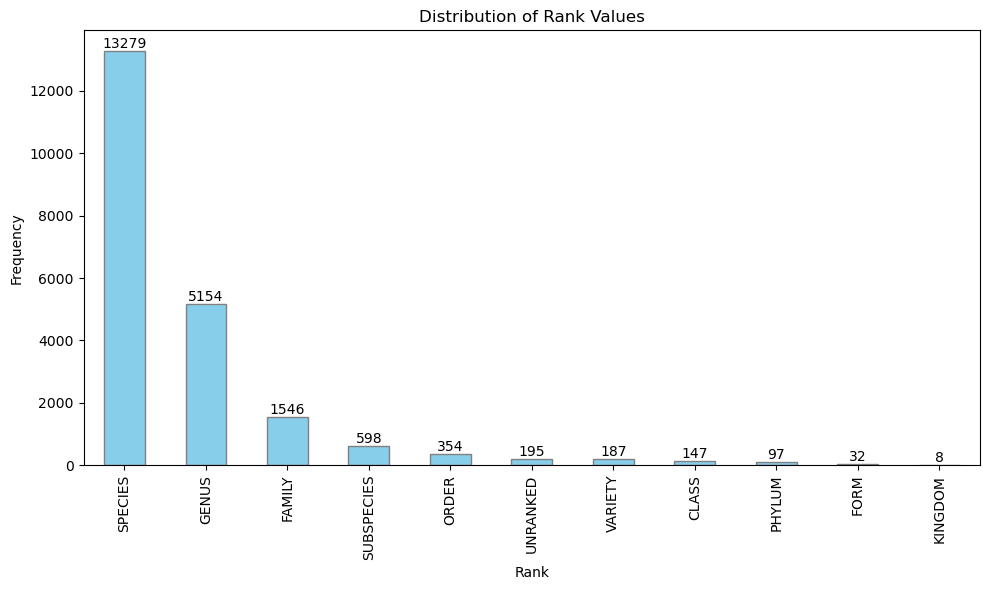

In [41]:

# Count the occurrences of each category in the 'rank' column
rank_counts = entities_df['rank'].value_counts()


# Plotting the distribution of the 'rank' values
plt.figure(figsize=(10, 6))
bars = rank_counts.plot(kind='bar', color='skyblue', edgecolor='grey')

# Adding labels and title
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Distribution of Rank Values')

# Adding the counts above the bars
for bar in bars.containers[0]:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        color='black',
        fontsize=10
    )

# Display the plot
plt.tight_layout()
plt.show()


In [42]:
entities_df.columns.to_list()

['gbif_id',
 'name',
 'usageKey',
 'acceptedUsageKey',
 'scientificName',
 'canonicalName',
 'rank',
 'status',
 'confidence',
 'note',
 'matchType',
 'kingdom',
 'phylum',
 'order',
 'family',
 'genus',
 'subgenus',
 'species',
 'kingdomKey',
 'phylumKey',
 'classKey',
 'orderKey',
 'familyKey',
 'genusKey',
 'subgenusKey',
 'speciesKey',
 'class']

In [60]:

# Filter entities_df to only include rows where 'rank' is 'SPECIES'
species_df = entities_df[entities_df['rank'] == 'SPECIES']
species_df


,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
7,GBIF:1000410,Methanogenium frigidum,NaN,NaN,"Methanogenium frigidum Franzmann et al., 1997",Methanogenium frigidum,SPECIES,NaN,NaN,NaN,...,Methanogenium frigidum,2,10764301.0,162.0,566.0,7789.0,1000372.0,NaN,1000410.0,Methanomicrobia
9,GBIF:1000447,Hexarthra mira,NaN,NaN,"Hexarthra mira (Hudson, 1871)",Hexarthra mira,SPECIES,NaN,NaN,NaN,...,Hexarthra mira,1,91.0,307.0,1005.0,7519.0,1000426.0,NaN,1000447.0,Eurotatoria
12,GBIF:1001202,Habrotrocha angusticollis,NaN,NaN,"Habrotrocha angusticollis (Murray, 1905)",Habrotrocha angusticollis,SPECIES,NaN,NaN,NaN,...,Habrotrocha angusticollis,1,91.0,307.0,1234.0,8056.0,1001165.0,NaN,1001202.0,Eurotatoria
14,GBIF:1001917,Asplanchna girodi,NaN,NaN,"Asplanchna girodi de Guerne, 1888",Asplanchna girodi,SPECIES,NaN,NaN,NaN,...,Asplanchna girodi,1,91.0,307.0,1235.0,8059.0,1001916.0,NaN,1001917.0,Eurotatoria
18,GBIF:1002486,Lecane inermis,NaN,NaN,"Lecane inermis (Bryce, 1892)",Lecane inermis,SPECIES,NaN,NaN,NaN,...,Lecane inermis,1,91.0,307.0,1235.0,8064.0,1002167.0,NaN,1002486.0,Eurotatoria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21587,GBIF:9958093,Epeira spec,NaN,NaN,"Epeira spec Thorell, 1875",Epeira spec,SPECIES,NaN,NaN,NaN,...,Araneus spec,1,54.0,367.0,1496.0,7359.0,2159718.0,NaN,9878247.0,Arachnida
21589,GBIF:9977012,Phyllanthus emblica,NaN,NaN,Phyllanthus emblica,Phyllanthus emblica,SPECIES,NaN,NaN,NaN,...,Phyllanthus emblica,1,44.0,212.0,729.0,6101112.0,2493569.0,NaN,9977012.0,Aves
21593,GBIF:9982023,Spinturnix andegavinus,NaN,NaN,"Spinturnix andegavinus Deunff, 1977",Spinturnix andegavinus,SPECIES,NaN,NaN,NaN,...,Spinturnix andegavinus,1,54.0,367.0,1109.0,4549059.0,4407627.0,NaN,9982023.0,Arachnida
21594,GBIF:9990095,Curruca melanocephala,NaN,NaN,"Curruca melanocephala (J.F.Gmelin, 1789)",Curruca melanocephala,SPECIES,NaN,NaN,NaN,...,Curruca melanocephala,1,44.0,212.0,729.0,5285.0,7988924.0,NaN,9990095.0,Aves


In [61]:
species_df[species_df['gbif_id'] == 'GBIF:3183002']

,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
9026,GBIF:3183002,clove,NaN,NaN,Syzygium aromaticum (L.) Merr. & L.M.Perry,Syzygium aromaticum,SPECIES,NaN,NaN,NaN,...,Syzygium aromaticum,6,7707728.0,220.0,690.0,5014.0,3029010.0,NaN,3183002.0,Magnoliopsida
9027,GBIF:3183002,Syzygium aromaticum,NaN,NaN,Syzygium aromaticum (L.) Merr. & L.M.Perry,Syzygium aromaticum,SPECIES,NaN,NaN,NaN,...,Syzygium aromaticum,6,7707728.0,220.0,690.0,5014.0,3029010.0,NaN,3183002.0,Magnoliopsida


In [62]:
# Function to create tuples with 'GBIF:' prefix
def create_tuple_with_prefix(df, name_col, key_col):
    return df.apply(lambda row: (f"GBIF:{int(row[key_col])}" if not pd.isna(row[key_col]) else None, row[name_col]), axis=1)

# Adding tuple columns with 'GBIF:' prefix
species_df['kingdom_tuple'] = create_tuple_with_prefix(species_df, 'kingdom', 'kingdomKey')
species_df['phylum_tuple'] = create_tuple_with_prefix(species_df, 'phylum', 'phylumKey')
species_df['class_tuple'] = create_tuple_with_prefix(species_df, 'class', 'classKey')
species_df['order_tuple'] = create_tuple_with_prefix(species_df, 'order', 'orderKey')
species_df['family_tuple'] = create_tuple_with_prefix(species_df, 'family', 'familyKey')
species_df['genus_tuple'] = create_tuple_with_prefix(species_df, 'genus', 'genusKey')
species_df['species_tuple'] = create_tuple_with_prefix(species_df, 'species', 'speciesKey')

# Selecting the relevant columns
#species_df = species_df[['species_tuple', 'genus_tuple', 'family_tuple', 'order_tuple', 'class_tuple', 'phylum_tuple', 'kingdom_tuple']]
species_df

C:\Users\maria\AppData\Local\Temp\ipykernel_17896\2779240816.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_df['kingdom_tuple'] = create_tuple_with_prefix(species_df, 'kingdom', 'kingdomKey')
C:\Users\maria\AppData\Local\Temp\ipykernel_17896\2779240816.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_df['phylum_tuple'] = create_tuple_with_prefix(species_df, 'phylum', 'phylumKey')
C:\Users\maria\AppData\Local\Temp\ipykernel_17896\2779240816.py:8: SettingWithCopyWarning: 
A value is tr

,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,subgenusKey,speciesKey,class,kingdom_tuple,phylum_tuple,class_tuple,order_tuple,family_tuple,genus_tuple,species_tuple
7,GBIF:1000410,Methanogenium frigidum,NaN,NaN,"Methanogenium frigidum Franzmann et al., 1997",Methanogenium frigidum,SPECIES,NaN,NaN,NaN,...,NaN,1000410.0,Methanomicrobia,"(GBIF:2, Archaea)","(GBIF:10764301, Halobacteriota)","(GBIF:162, Methanomicrobia)","(GBIF:566, Methanomicrobiales)","(GBIF:7789, Methanomicrobiaceae)","(GBIF:1000372, Methanogenium)","(GBIF:1000410, Methanogenium frigidum)"
9,GBIF:1000447,Hexarthra mira,NaN,NaN,"Hexarthra mira (Hudson, 1871)",Hexarthra mira,SPECIES,NaN,NaN,NaN,...,NaN,1000447.0,Eurotatoria,"(GBIF:1, Animalia)","(GBIF:91, Rotifera)","(GBIF:307, Eurotatoria)","(GBIF:1005, Flosculariaceae)","(GBIF:7519, Hexarthridae)","(GBIF:1000426, Hexarthra)","(GBIF:1000447, Hexarthra mira)"
12,GBIF:1001202,Habrotrocha angusticollis,NaN,NaN,"Habrotrocha angusticollis (Murray, 1905)",Habrotrocha angusticollis,SPECIES,NaN,NaN,NaN,...,NaN,1001202.0,Eurotatoria,"(GBIF:1, Animalia)","(GBIF:91, Rotifera)","(GBIF:307, Eurotatoria)","(GBIF:1234, Bdelloidea)","(GBIF:8056, Habrotrochidae)","(GBIF:1001165, Habrotrocha)","(GBIF:1001202, Habrotrocha angusticollis)"
14,GBIF:1001917,Asplanchna girodi,NaN,NaN,"Asplanchna girodi de Guerne, 1888",Asplanchna girodi,SPECIES,NaN,NaN,NaN,...,NaN,1001917.0,Eurotatoria,"(GBIF:1, Animalia)","(GBIF:91, Rotifera)","(GBIF:307, Eurotatoria)","(GBIF:1235, Ploima)","(GBIF:8059, Asplanchnidae)","(GBIF:1001916, Asplanchna)","(GBIF:1001917, Asplanchna girodi)"
18,GBIF:1002486,Lecane inermis,NaN,NaN,"Lecane inermis (Bryce, 1892)",Lecane inermis,SPECIES,NaN,NaN,NaN,...,NaN,1002486.0,Eurotatoria,"(GBIF:1, Animalia)","(GBIF:91, Rotifera)","(GBIF:307, Eurotatoria)","(GBIF:1235, Ploima)","(GBIF:8064, Lecanidae)","(GBIF:1002167, Lecane)","(GBIF:1002486, Lecane inermis)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21587,GBIF:9958093,Epeira spec,NaN,NaN,"Epeira spec Thorell, 1875",Epeira spec,SPECIES,NaN,NaN,NaN,...,NaN,9878247.0,Arachnida,"(GBIF:1, Animalia)","(GBIF:54, Arthropoda)","(GBIF:367, Arachnida)","(GBIF:1496, Araneae)","(GBIF:7359, Araneidae)","(GBIF:2159718, Araneus)","(GBIF:9878247, Araneus spec)"
21589,GBIF:9977012,Phyllanthus emblica,NaN,NaN,Phyllanthus emblica,Phyllanthus emblica,SPECIES,NaN,NaN,NaN,...,NaN,9977012.0,Aves,"(GBIF:1, Animalia)","(GBIF:44, Chordata)","(GBIF:212, Aves)","(GBIF:729, Passeriformes)","(GBIF:6101112, Leiothrichidae)","(GBIF:2493569, Phyllanthus)","(GBIF:9977012, Phyllanthus emblica)"
21593,GBIF:9982023,Spinturnix andegavinus,NaN,NaN,"Spinturnix andegavinus Deunff, 1977",Spinturnix andegavinus,SPECIES,NaN,NaN,NaN,...,NaN,9982023.0,Arachnida,"(GBIF:1, Animalia)","(GBIF:54, Arthropoda)","(GBIF:367, Arachnida)","(GBIF:1109, Mesostigmata)","(GBIF:4549059, Spinturnicidae)","(GBIF:4407627, Spinturnix)","(GBIF:9982023, Spinturnix andegavinus)"
21594,GBIF:9990095,Curruca melanocephala,NaN,NaN,"Curruca melanocephala (J.F.Gmelin, 1789)",Curruca melanocephala,SPECIES,NaN,NaN,NaN,...,NaN,9990095.0,Aves,"(GBIF:1, Animalia)","(GBIF:44, Chordata)","(GBIF:212, Aves)","(GBIF:729, Passeriformes)","(GBIF:5285, Sylviidae)","(GBIF:7988924, Curruca)","(GBIF:9990095, Curruca melanocephala)"


In [64]:
species_df[species_df['gbif_id'] == 'GBIF:3183002']
#species_df.loc[9026]

,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,subgenusKey,speciesKey,class,kingdom_tuple,phylum_tuple,class_tuple,order_tuple,family_tuple,genus_tuple,species_tuple
9026,GBIF:3183002,clove,NaN,NaN,Syzygium aromaticum (L.) Merr. & L.M.Perry,Syzygium aromaticum,SPECIES,NaN,NaN,NaN,...,NaN,3183002.0,Magnoliopsida,"(GBIF:6, Plantae)","(GBIF:7707728, Tracheophyta)","(GBIF:220, Magnoliopsida)","(GBIF:690, Myrtales)","(GBIF:5014, Myrtaceae)","(GBIF:3029010, Syzygium)","(GBIF:3183002, Syzygium aromaticum)"
9027,GBIF:3183002,Syzygium aromaticum,NaN,NaN,Syzygium aromaticum (L.) Merr. & L.M.Perry,Syzygium aromaticum,SPECIES,NaN,NaN,NaN,...,NaN,3183002.0,Magnoliopsida,"(GBIF:6, Plantae)","(GBIF:7707728, Tracheophyta)","(GBIF:220, Magnoliopsida)","(GBIF:690, Myrtales)","(GBIF:5014, Myrtaceae)","(GBIF:3029010, Syzygium)","(GBIF:3183002, Syzygium aromaticum)"


In [68]:
# List of phylogeny fields
phylogeny_fields = [
    'kingdom_tuple',
    'phylum_tuple',
    'class_tuple',
    'order_tuple',
    'family_tuple',
    'genus_tuple',
    'species_tuple'
]

species_df[phylogeny_fields]

,kingdom_tuple,phylum_tuple,class_tuple,order_tuple,family_tuple,genus_tuple,species_tuple
7,"(GBIF:2, Archaea)","(GBIF:10764301, Halobacteriota)","(GBIF:162, Methanomicrobia)","(GBIF:566, Methanomicrobiales)","(GBIF:7789, Methanomicrobiaceae)","(GBIF:1000372, Methanogenium)","(GBIF:1000410, Methanogenium frigidum)"
9,"(GBIF:1, Animalia)","(GBIF:91, Rotifera)","(GBIF:307, Eurotatoria)","(GBIF:1005, Flosculariaceae)","(GBIF:7519, Hexarthridae)","(GBIF:1000426, Hexarthra)","(GBIF:1000447, Hexarthra mira)"
12,"(GBIF:1, Animalia)","(GBIF:91, Rotifera)","(GBIF:307, Eurotatoria)","(GBIF:1234, Bdelloidea)","(GBIF:8056, Habrotrochidae)","(GBIF:1001165, Habrotrocha)","(GBIF:1001202, Habrotrocha angusticollis)"
14,"(GBIF:1, Animalia)","(GBIF:91, Rotifera)","(GBIF:307, Eurotatoria)","(GBIF:1235, Ploima)","(GBIF:8059, Asplanchnidae)","(GBIF:1001916, Asplanchna)","(GBIF:1001917, Asplanchna girodi)"
18,"(GBIF:1, Animalia)","(GBIF:91, Rotifera)","(GBIF:307, Eurotatoria)","(GBIF:1235, Ploima)","(GBIF:8064, Lecanidae)","(GBIF:1002167, Lecane)","(GBIF:1002486, Lecane inermis)"
...,...,...,...,...,...,...,...
21587,"(GBIF:1, Animalia)","(GBIF:54, Arthropoda)","(GBIF:367, Arachnida)","(GBIF:1496, Araneae)","(GBIF:7359, Araneidae)","(GBIF:2159718, Araneus)","(GBIF:9878247, Araneus spec)"
21589,"(GBIF:1, Animalia)","(GBIF:44, Chordata)","(GBIF:212, Aves)","(GBIF:729, Passeriformes)","(GBIF:6101112, Leiothrichidae)","(GBIF:2493569, Phyllanthus)","(GBIF:9977012, Phyllanthus emblica)"
21593,"(GBIF:1, Animalia)","(GBIF:54, Arthropoda)","(GBIF:367, Arachnida)","(GBIF:1109, Mesostigmata)","(GBIF:4549059, Spinturnicidae)","(GBIF:4407627, Spinturnix)","(GBIF:9982023, Spinturnix andegavinus)"
21594,"(GBIF:1, Animalia)","(GBIF:44, Chordata)","(GBIF:212, Aves)","(GBIF:729, Passeriformes)","(GBIF:5285, Sylviidae)","(GBIF:7988924, Curruca)","(GBIF:9990095, Curruca melanocephala)"


In [67]:
species_df.columns.to_list()

['gbif_id',
 'name',
 'usageKey',
 'acceptedUsageKey',
 'scientificName',
 'canonicalName',
 'rank',
 'status',
 'confidence',
 'note',
 'matchType',
 'kingdom',
 'phylum',
 'order',
 'family',
 'genus',
 'subgenus',
 'species',
 'kingdomKey',
 'phylumKey',
 'classKey',
 'orderKey',
 'familyKey',
 'genusKey',
 'subgenusKey',
 'speciesKey',
 'class',
 'kingdom_tuple',
 'phylum_tuple',
 'class_tuple',
 'order_tuple',
 'family_tuple',
 'genus_tuple',
 'species_tuple']

In [73]:
species_df.to_csv('C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/species_GBIF.csv', index=False, encoding='utf-8' )

## Merging entities phylogeny with papers_df

In [15]:
# Load the Excel file
file_path = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities-all-MD_GBIF_v3.csv'
papers_df = pd.read_csv(file_path)

species_df= pd.read_csv('C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/species_GBIF.csv',  encoding='utf-8' )

def safe_flatten_and_count(row):
    try:
        # Assuming the row is a properly formatted string list of lists
        evaluated_row = ast.literal_eval(row)
        flattened = [(item[0], item[1]) for sublist in evaluated_row for item in sublist]
        result = Counter(flattened)
        return result
    
    except ValueError:
        # Handle or log the error as appropriate
        return 'Error'

# Apply this function to the 'TaxoEntitiesMD2_GBIF' column
# This assumes the rest of your DataFrame manipulation has worked as expected
papers_df['TaxoEntities_Count'] = papers_df['TaxoEntitiesMD2_GBIF'].apply(safe_flatten_and_count)
papers_df

,fileMain_s,TaxoEntitiesMD2_GBIF,TaxoEntities_Count
0,https://hal.inrae.fr/hal-03461601/document,"[[('GBIF:3183002', 'clove', 0.7634411454200745...","{('GBIF:3183002', 'clove'): 11, ('GBIF:3183002..."
1,https://hal.science/hal-03829927/document,"[[('GBIF:9065640', 'Tyto novaehollandiae novae...","{('GBIF:9065640', 'Tyto novaehollandiae novaeh..."
2,https://hal.science/hal-02350603/document,[],{}
3,https://shs.hal.science/halshs-02937670/document,"[[('GBIF:5786457', 'Sateré Marmoset', 0.771187...","{('GBIF:5786457', 'Sateré Marmoset'): 3, ('GBI..."
4,https://cnam.hal.science/hal-04080723/document,"[[('GBIF:4494312', 'Spilomena beata Blüthgen',...","{('GBIF:4494312', 'Spilomena beata Blüthgen'):..."
...,...,...,...
1151,https://hal.sorbonne-universite.fr/hal-0295053...,"[[('GBIF:2368377', 'Oryzias latipes', 1.0)], [...","{('GBIF:2368377', 'Oryzias latipes'): 2, ('GBI..."
1152,https://u-picardie.hal.science/hal-03619105/do...,"[[('GBIF:4667268', 'Agustina', 0.7207658290863...","{('GBIF:4667268', 'Agustina'): 2, ('GBIF:85988..."
1153,https://hal.inrae.fr/hal-02636091/document,"[[('GBIF:2438660', 'European Pine Vole', 0.730...","{('GBIF:2438660', 'European Pine Vole'): 1, ('..."
1154,https://hal.science/hal-04167917/document,"[[('GBIF:2432958', 'Hypsignathus monstrosus', ...","{('GBIF:2432958', 'Hypsignathus monstrosus'): ..."


In [16]:
papers_df[papers_df['TaxoEntities_Count'] == 'Error']

,fileMain_s,TaxoEntitiesMD2_GBIF,TaxoEntities_Count
516,https://ird.hal.science/ird-00195246/document,Error2,Error


In [17]:
papers_df.columns.to_list()

['fileMain_s', 'TaxoEntitiesMD2_GBIF', 'TaxoEntities_Count']

In [18]:
# Extending the DataFrame to add 'Species_Count'
def extract_matching_species(entity_count, species_df):
    species_set = set((row['gbif_id'], row['name']) for idx, row in species_df.iterrows())
    matching_species = [Counter({entity: count}) for entity, count in entity_count.items() if entity in species_set]
    return matching_species

# Add 'Species_Count' column
papers_df['Species_Count'] = papers_df['TaxoEntities_Count'].apply(lambda x: extract_matching_species(x, species_df))



AttributeError: 'str' object has no attribute 'items'

In [19]:

# Debugging function to check the matching logic
def extract_matching_species(entity_count, species_df):
    species_keys = set(key for key, name in species_df['species_tuple'])
    matching_species = [Counter({entity: count}) for entity, count in entity_count.items() if entity[0] in species_keys]
    
    return matching_species

# Add 'Species_Count' column
papers_df['Species_Count'] = papers_df['TaxoEntities_Count'].apply(lambda x: extract_matching_species(x, species_df))

papers_df

ValueError: too many values to unpack (expected 2)

In [66]:
papers_df

,fileMain_s,TaxoEntitiesMD2_GBIF,TaxoEntities_Count,Species_Count
0,https://hal.inrae.fr/hal-03461601/document,"[[('GBIF:3183002', 'clove', 0.7634411454200745...","{('GBIF:3183002', 'clove'): 11, ('GBIF:3183002...","[{('GBIF:3183002', 'clove'): 11}, {('GBIF:3183..."
1,https://hal.science/hal-03829927/document,"[[('GBIF:9065640', 'Tyto novaehollandiae novae...","{('GBIF:9065640', 'Tyto novaehollandiae novaeh...","[{('GBIF:5232358', 'Tyto tenebricosa'): 2}, {(..."
2,https://hal.science/hal-02350603/document,[],{},[]
3,https://shs.hal.science/halshs-02937670/document,"[[('GBIF:5786457', 'Sateré Marmoset', 0.771187...","{('GBIF:5786457', 'Sateré Marmoset'): 3, ('GBI...","[{('GBIF:5786457', 'Sateré Marmoset'): 3}, {('..."
4,https://cnam.hal.science/hal-04080723/document,"[[('GBIF:4494312', 'Spilomena beata Blüthgen',...","{('GBIF:4494312', 'Spilomena beata Blüthgen'):...","[{('GBIF:4494312', 'Spilomena beata Blüthgen')..."
...,...,...,...,...
1151,https://hal.sorbonne-universite.fr/hal-0295053...,"[[('GBIF:2368377', 'Oryzias latipes', 1.0)], [...","{('GBIF:2368377', 'Oryzias latipes'): 2, ('GBI...","[{('GBIF:2368377', 'Oryzias latipes'): 2}, {('..."
1152,https://u-picardie.hal.science/hal-03619105/do...,"[[('GBIF:4667268', 'Agustina', 0.7207658290863...","{('GBIF:4667268', 'Agustina'): 2, ('GBIF:85988...","[{('GBIF:7424736', 'Lupinus nootkatensis'): 1}..."
1153,https://hal.inrae.fr/hal-02636091/document,"[[('GBIF:2438660', 'European Pine Vole', 0.730...","{('GBIF:2438660', 'European Pine Vole'): 1, ('...","[{('GBIF:2438660', 'European Pine Vole'): 1}, ..."
1154,https://hal.science/hal-04167917/document,"[[('GBIF:2432958', 'Hypsignathus monstrosus', ...","{('GBIF:2432958', 'Hypsignathus monstrosus'): ...","[{('GBIF:2432958', 'Hypsignathus monstrosus'):..."


In [71]:
# Function to extract matching species and their counts for each phylogeny field
def extract_matching_species_and_phylogeny(entity_count, species_df, phylogeny_fields):
    # Initialize counters for each phylogeny field
    phylogeny_counters = {field: Counter() for field in phylogeny_fields}
    
    for entity, count in entity_count.items():
        entity_key = entity[0]
        matching_rows = species_df[species_df['species_tuple'].apply(lambda x: x[0]) == entity_key]
        for _, row in matching_rows.iterrows():
            for field in phylogeny_fields:
                phylogeny_counters[field][row[field]] += count
    
    # Combine the counters into a dictionary
    combined_counters = {field: phylogeny_counters[field] for field in phylogeny_fields}
    # Sort the counters and convert them to lists
    sorted_counters = {field: sorted(combined_counters[field].items(), key=lambda x: x[1], reverse=True) for field in phylogeny_fields}
    return sorted_counters

# Add new columns for each phylogeny field
for field in phylogeny_fields:
    papers_df[f'{field}_Count'] = papers_df['TaxoEntities_Count'].apply(lambda x: extract_matching_species_and_phylogeny(x, species_df, phylogeny_fields)[field])
papers_df

,fileMain_s,TaxoEntitiesMD2_GBIF,TaxoEntities_Count,Species_Count,kingdom_tuple_Count,phylum_tuple_Count,class_tuple_Count,order_tuple_Count,family_tuple_Count,genus_tuple_Count,species_tuple_Count
0,https://hal.inrae.fr/hal-03461601/document,"[[('GBIF:3183002', 'clove', 0.7634411454200745...","{('GBIF:3183002', 'clove'): 11, ('GBIF:3183002...","[{('GBIF:3183002', 'clove'): 11}, {('GBIF:3183...","[((GBIF:6, Plantae), 141), ((GBIF:1, Animalia)...","[((GBIF:7707728, Tracheophyta), 141), ((GBIF:4...","[((GBIF:220, Magnoliopsida), 73), ((GBIF:196, ...","[((GBIF:627, Zingiberales), 58), ((GBIF:1104, ...","[((GBIF:4686, Musaceae), 56), ((GBIF:7163, Alb...","[((GBIF:2760990, Musa), 56), ((GBIF:2341074, A...","[((GBIF:5204104, Albula vulpes), 28), ((GBIF:3..."
1,https://hal.science/hal-03829927/document,"[[('GBIF:9065640', 'Tyto novaehollandiae novae...","{('GBIF:9065640', 'Tyto novaehollandiae novaeh...","[{('GBIF:5232358', 'Tyto tenebricosa'): 2}, {(...","[((GBIF:1, Animalia), 186), ((GBIF:6, Plantae)...","[((GBIF:44, Chordata), 177), ((GBIF:54, Arthro...","[((GBIF:359, Mammalia), 148), ((GBIF:212, Aves...","[((GBIF:1459, Rodentia), 54), ((GBIF:736, Dasy...","[((GBIF:5510, Muridae), 46), ((GBIF:5452, Dasy...","[((GBIF:2438300, Pseudomys), 22), ((GBIF:24353...","[((GBIF:2440062, Pseudocheirus peregrinus), 16..."
2,https://hal.science/hal-02350603/document,[],{},[],[],[],[],[],[],[],[]
3,https://shs.hal.science/halshs-02937670/document,"[[('GBIF:5786457', 'Sateré Marmoset', 0.771187...","{('GBIF:5786457', 'Sateré Marmoset'): 3, ('GBI...","[{('GBIF:5786457', 'Sateré Marmoset'): 3}, {('...","[((GBIF:6, Plantae), 112), ((GBIF:1, Animalia)...","[((GBIF:7707728, Tracheophyta), 112), ((GBIF:4...","[((GBIF:220, Magnoliopsida), 112), ((GBIF:359,...","[((GBIF:933, Sapindales), 106), ((GBIF:798, Pr...","[((GBIF:6657, Sapindaceae), 105), ((GBIF:9620,...","[((GBIF:3189948, Paullinia), 105), ((GBIF:7826...","[((GBIF:3189949, Paullinia cupana), 105), ((GB..."
4,https://cnam.hal.science/hal-04080723/document,"[[('GBIF:4494312', 'Spilomena beata Blüthgen',...","{('GBIF:4494312', 'Spilomena beata Blüthgen'):...","[{('GBIF:4494312', 'Spilomena beata Blüthgen')...","[((GBIF:1, Animalia), 3), ((GBIF:6, Plantae), 2)]","[((GBIF:54, Arthropoda), 3), ((GBIF:7707728, T...","[((GBIF:216, Insecta), 3), ((GBIF:220, Magnoli...","[((GBIF:1457, Hymenoptera), 3), ((GBIF:933, Sa...","[((GBIF:7906, Crabronidae), 3), ((GBIF:2397, M...","[((GBIF:1346854, Spilomena), 3), ((GBIF:710797...","[((GBIF:4494312, Spilomena beata), 3), ((GBIF:..."
...,...,...,...,...,...,...,...,...,...,...,...
1151,https://hal.sorbonne-universite.fr/hal-0295053...,"[[('GBIF:2368377', 'Oryzias latipes', 1.0)], [...","{('GBIF:2368377', 'Oryzias latipes'): 2, ('GBI...","[{('GBIF:2368377', 'Oryzias latipes'): 2}, {('...","[((GBIF:1, Animalia), 124)]","[((GBIF:44, Chordata), 109), ((GBIF:54, Arthro...","[((None, nan), 97), ((GBIF:359, Mammalia), 12)...","[((GBIF:1313, Salmoniformes), 34), ((GBIF:1459...","[((GBIF:8615, Salmonidae), 34), ((GBIF:5510, M...","[((GBIF:2351426, Oncorhynchus), 34), ((GBIF:98...","[((GBIF:5204019, Oncorhynchus mykiss), 32), ((..."
1152,https://u-picardie.hal.science/hal-03619105/do...,"[[('GBIF:4667268', 'Agustina', 0.7207658290863...","{('GBIF:4667268', 'Agustina'): 2, ('GBIF:85988...","[{('GBIF:7424736', 'Lupinus nootkatensis'): 1}...","[((GBIF:6, Plantae), 52), ((GBIF:1, Animalia),...","[((GBIF:7707728, Tracheophyta), 52), ((GBIF:44...","[((GBIF:220, Magnoliopsida), 37), ((GBIF:194, ...","[((GBIF:414, Asterales), 20), ((GBIF:408, Lami...","[((GBIF:3065, Asteraceae), 20), ((GBIF:2390, S...","[((GBIF:7787708, Taraxacum), 20), ((GBIF:29289...","[((GBIF:5394163, Taraxacum officinale), 15), (..."
1153,https://hal.inrae.fr/hal-02636091/document,"[[('GBIF:2438660', 'European Pine Vole', 0.730...","{('GBIF:2438660', 'European Pine Vole'): 1, ('...","[{('GBIF:2438660', 'European Pine Vole'): 1}, ...","[((GBIF:6, Plantae), 216), ((GBIF:1, Animalia)...","[((GBIF:7707728, Tracheoph

In [72]:
papers_df.to_csv('C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/papers_phylogeny_ordered.csv', index=False, encoding='utf-8' )

# Knowledge Graph - Building from GBIF DB

In [ ]:
# Initialize the directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph with additional attributes
for _, row in df.iterrows():
    kingdom = str(row['kingdom']) if pd.notna(row['kingdom']) else None
    phylum = str(row['phylum']) if pd.notna(row['phylum']) else None
    class_ = str(row['class']) if pd.notna(row['class']) else None
    order = str(row['order']) if pd.notna(row['order']) else None
    family = str(row['family']) if pd.notna(row['family']) else None
    genus = str(row['genus']) if pd.notna(row['genus']) else None
    species = str(row['species']) if pd.notna(row['species']) else None

    if kingdom:
        G.add_node(kingdom, level='kingdom', label=kingdom)
    if phylum:
        G.add_node(phylum, level='phylum', label=phylum)
        G.add_edge(kingdom, phylum)
    if class_:
        G.add_node(class_, level='class', label=class_)
        G.add_edge(phylum, class_)
    if order:
        G.add_node(order, level='order', label=order)
        G.add_edge(class_, order)
    if family:
        G.add_node(family, level='family', label=family)
        G.add_edge(order, family)
    if genus:
        G.add_node(genus, level='genus', label=genus)
        G.add_edge(family, genus)
    if species:
        G.add_node(species, level='species', label=species)
        G.add_edge(genus, species)


# Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_color='black', edge_color='grey')
plt.title("Phylogenetic Tree")
plt.show()


In [12]:
import pandas as pd
import networkx as nx
from pyvis.network import Network

# Initialize the directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph with additional attributes
for _, row in df.iterrows():
    kingdom = str(row['kingdom']) if pd.notna(row['kingdom']) else None
    phylum = str(row['phylum']) if pd.notna(row['phylum']) else None
    class_ = str(row['class']) if pd.notna(row['class']) else None
    order = str(row['order']) if pd.notna(row['order']) else None
    family = str(row['family']) if pd.notna(row['family']) else None
    genus = str(row['genus']) if pd.notna(row['genus']) else None
    species = str(row['species']) if pd.notna(row['species']) else None

    if kingdom:
        G.add_node(kingdom, level='kingdom', label=kingdom)
    if phylum:
        G.add_node(phylum, level='phylum', label=phylum)
        if kingdom:
            G.add_edge(kingdom, phylum)
    if class_:
        G.add_node(class_, level='class', label=class_)
        if phylum:
            G.add_edge(phylum, class_)
    if order:
        G.add_node(order, level='order', label=order)
        if class_:
            G.add_edge(class_, order)
    if family:
        G.add_node(family, level='family', label=family)
        if order:
            G.add_edge(order, family)
    if genus:
        G.add_node(genus, level='genus', label=genus)
        if family:
            G.add_edge(family, genus)
    if species:
        G.add_node(species, level='species', label=species)
        if genus:
            G.add_edge(genus, species)

# Create a Pyvis network
net = Network(notebook=True, height='750px', width='100%', directed=True, cdn_resources='remote')

# Load the NetworkX graph into Pyvis
net.from_nx(G)

# Customize the visualization
net.show_buttons(filter_=['physics'])
net.show("phylogenetic_tree.html")


phylogenetic_tree.html


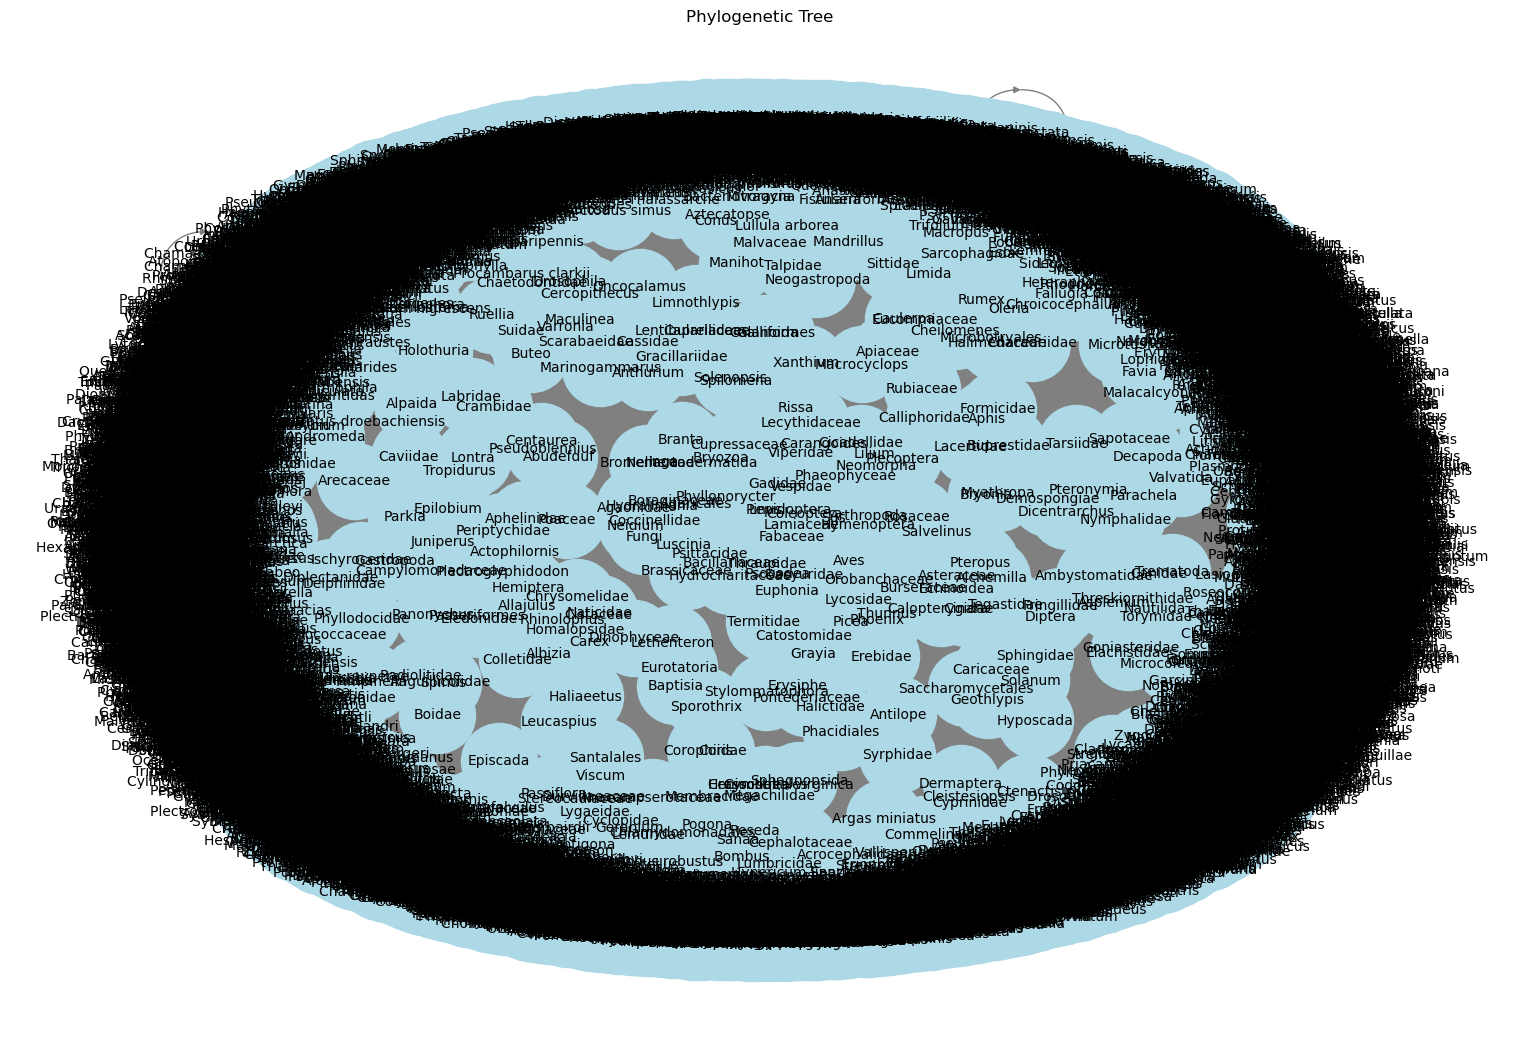

In [13]:
# Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_color='black', edge_color='grey')
plt.title("Phylogenetic Tree")
plt.show()

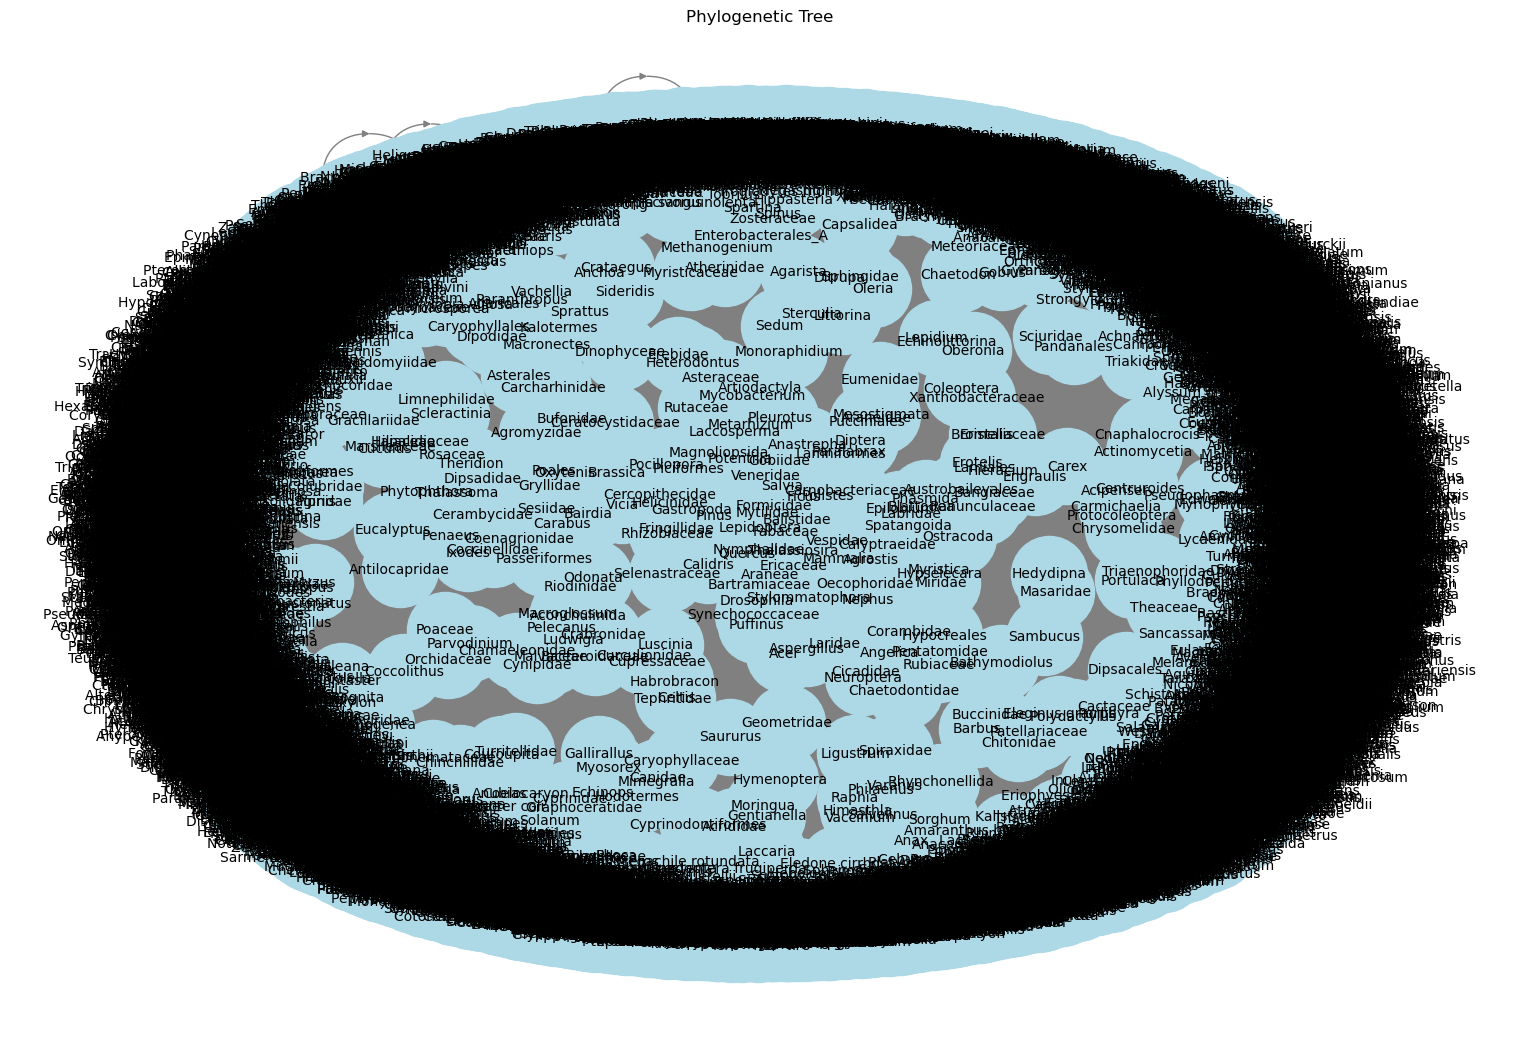

In [14]:
# Draw the graph using spring layout and save as an image
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), node_size=3000, node_color='lightblue', font_size=10, font_color='black', edge_color='grey')
plt.title("Phylogenetic Tree")
plt.savefig("phylogenetic_tree.png", format="PNG")  # Save the figure as a PNG file
plt.show()

In [8]:
!pip install pyvis


   ---------------------------------------- 756.0/756.0 kB 1.0 MB/s eta 0:00:00


In [10]:
# Create a Pyvis network
net = Network(notebook=True, height='750px', width='100%', directed=True, cdn_resources='remote')

# Load the NetworkX graph into Pyvis
net.from_nx(G)

# Customize the visualization
net.show_buttons(filter_=['physics'])
net.show("phylogenetic_tree.html")

AssertionError: 

In [6]:
# Save the graph to a GraphML file
nx.write_graphml(G, "C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/phylogenetic_tree.graphml")

# Save the graph to a GEXF file
nx.write_gexf(G, "C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/phylogenetic_tree.gexf")

# Load the graph from a GraphML file
G_loaded_graphml = nx.read_graphml("C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/phylogenetic_tree.graphml")

# Load the graph from a GEXF file
G_loaded_gexf = nx.read_gexf("C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/phylogenetic_tree.gexf")

# Verify that the loaded graphs are the same as the original graph
def graph_info(graph):
    print(f"Graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges")
    print("Nodes:", list(graph.nodes(data=True))[:5])  # Display the first 5 nodes with their attributes
    print("Edges:", list(graph.edges(data=True))[:5])  # Display the first 5 edges with their attributes

print("GraphML Loaded Graph Info:")
graph_info(G_loaded_graphml)
print("\nGEXF Loaded Graph Info:")
graph_info(G_loaded_gexf)

GraphML Loaded Graph Info:
Graph with 20631 nodes and 21251 edges
Nodes: [('Animalia', {'level': 'kingdom'}), ('Arthropoda', {'level': 'phylum'}), ('Insecta', {'level': 'class'}), ('Mecoptera', {'level': 'order'}), ('Archaea', {'level': 'kingdom'})]
Edges: [('Animalia', 'Arthropoda', {}), ('Animalia', 'Rotifera', {}), ('Animalia', 'Annelida', {}), ('Animalia', 'Porifera', {}), ('Animalia', 'Mollusca', {})]

GEXF Loaded Graph Info:
Graph with 20631 nodes and 21251 edges
Nodes: [('Animalia', {'level': 'kingdom', 'label': 'Animalia'}), ('Arthropoda', {'level': 'phylum', 'label': 'Arthropoda'}), ('Insecta', {'level': 'class', 'label': 'Insecta'}), ('Mecoptera', {'level': 'order', 'label': 'Mecoptera'}), ('Archaea', {'level': 'kingdom', 'label': 'Archaea'})]
Edges: [('Animalia', 'Arthropoda', {'id': '0'}), ('Animalia', 'Rotifera', {'id': '1'}), ('Animalia', 'Annelida', {'id': '2'}), ('Animalia', 'Porifera', {'id': '3'}), ('Animalia', 'Mollusca', {'id': '4'})]


In [15]:
!pip install owlready2


     -------------------------------------- 27.4/27.4 MB 606.9 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for owlready2: filename=owlready2-0.46-cp39-cp39-win_amd64.whl size=23458797 sha256=ff6bed5957364de39a0fbcc9959f9a5acc3a7a26d1cd89cac3dcfccd2fe66cc0
  Stored in directory: c:\users\maria\appdata\local\pip\cache\wheels\7d\ec\6b\1dd58efb7c3499c7b941645187d78a25f55aeb99303af09e66
Successfully built owlready2


In [16]:
from owlready2 import *

# Create a new ontology
onto = get_ontology("http://example.org/taxonomy.owl")

with onto:
    # Define classes
    class Taxon(Thing): pass
    class Kingdom(Taxon): pass
    class Phylum(Taxon): pass
    class Class(Taxon): pass
    class Order(Taxon): pass
    class Family(Taxon): pass
    class Genus(Taxon): pass
    class Species(Taxon): pass

    # Define properties
    class hasPhylum(Taxon >> Phylum): pass
    class hasClass(Taxon >> Class): pass
    class hasOrder(Taxon >> Order): pass
    class hasFamily(Taxon >> Family): pass
    class hasGenus(Taxon >> Genus): pass
    class hasSpecies(Taxon >> Species): pass

# Load the ontology
onto.load()

# Add instances based on your data
with onto:
    animalia = Kingdom("Animalia")
    arthropoda = Phylum("Arthropoda")
    insecta = Class("Insecta")
    mecoptera = Order("Mecoptera")
    methanobacterium = Genus("Methanobacterium")
    methanobacterium_fridigum = Species("Methanobacterium_fridigum")

    # Define relationships
    animalia.hasPhylum = [arthropoda]
    arthropoda.hasClass = [insecta]
    insecta.hasOrder = [mecoptera]
    mecoptera.hasGenus = [methanobacterium]
    methanobacterium.hasSpecies = [methanobacterium_fridigum]

# Save the ontology
onto.save(file = "taxonomy.owl")

# Perform reasoning
with onto:
    sync_reasoner()

# Query the inferred graph
for species in Species.instances():
    print(species)

# Check inferred properties
for genus in Genus.instances():
    print(f"{genus} has species: {genus.hasSpecies}")




* Owlready2 * Running HermiT...
    java -Xmx2000M -cp C:\Users\maria\anaconda3\lib\site-packages\owlready2\hermit;C:\Users\maria\anaconda3\lib\site-packages\owlready2\hermit\HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:///C:/Users/maria/AppData/Local/Temp/tmpl9vwp_tl
* Owlready2 * HermiT took 1.2572991847991943 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


taxonomy.Methanobacterium_fridigum
taxonomy.Methanobacterium has species: [taxonomy.Methanobacterium_fridigum]


## Creating RDF file based on CSV

In [18]:
#!pip install rdflib


  Using cached rdflib-7.0.0-py3-none-any.whl.metadata (11 kB)
   ---------------------------------------- 531.9/531.9 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 41.7/41.7 kB 2.1 MB/s eta 0:00:00


In [82]:
import pandas as pd
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS, OWL
import urllib.parse

# Load the CSV file
csv_file = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/species_GBIF.csv'
df = pd.read_csv(csv_file)


In [79]:


# Create RDF graph
g = Graph()

# Define namespaces
GBIF = Namespace("http://example.org/gbif/")
g.bind("gbif", GBIF)

# Define the hierarchy as per the given structure
hierarchy = ['kingdomKey','phylumKey','classKey','orderKey','familyKey','genusKey','subgenusKey','speciesKey']


# Create ontology classes
for h in hierarchy:
    class_uri = GBIF[h.capitalize()]
    g.add((class_uri, RDF.type, OWL.Class))
    if h != 'kingdomKey':
        parent_class_uri = GBIF[hierarchy[hierarchy.index(h) - 1].capitalize()]
        g.add((class_uri, RDFS.subClassOf, parent_class_uri))

# Function to create a valid URI from a string
def create_valid_uri(s):
    return URIRef(GBIF + urllib.parse.quote(s.replace(" ", "_")))

# Set to keep track of created entities
created_entities = set()

# Populate the graph with data from CSV
for _, row in df.iterrows():
    entity_uri = create_valid_uri(row['gbif_id'])
    if entity_uri not in created_entities:
        created_entities.add(entity_uri)
        g.add((entity_uri, RDF.type, GBIF[row['rank'].capitalize()]))

        for h in hierarchy:
            if pd.notna(row[h]):
                parent_uri = create_valid_uri(row[h])
                if parent_uri not in created_entities:
                    created_entities.add(parent_uri)
                    g.add((parent_uri, RDF.type, GBIF[h.capitalize()]))
                g.add((entity_uri, GBIF[h], parent_uri))

        g.add((entity_uri, GBIF['name'], Literal(row['name'])))
        g.add((entity_uri, GBIF['scientificName'], Literal(row['scientificName'])))
        g.add((entity_uri, GBIF['canonicalName'], Literal(row['canonicalName'])))
        g.add((entity_uri, GBIF['rank'], Literal(row['rank'])))

# Serialize the graph to an RDF file
output_file = 'species_GBIF.rdf'
g.serialize(destination=output_file, format='turtle')

print(f'RDF file has been created: {output_file}')


AttributeError: 'int' object has no attribute 'replace'

In [83]:
import pandas as pd
import rdflib
from rdflib.namespace import RDF, RDFS

# Create a new RDF graph
g = rdflib.Graph()

# Define namespaces
GBIF = rdflib.Namespace("http://www.gbif.org/species/")
EX = rdflib.Namespace("http://example.org/")

# Add namespaces to the graph
g.bind("gbif", GBIF)
g.bind("ex", EX)

# Function to create URIs for each level
def create_uri(namespace, identifier):
    return namespace[identifier]

# Loop through each row in the DataFrame and create RDF triples
for index, row in df.iterrows():
    kingdom_id, kingdom_name = eval(row['kingdom_tuple'])
    phylum_id, phylum_name = eval(row['phylum_tuple'])
    class_id, class_name = eval(row['class_tuple'])
    order_id, order_name = eval(row['order_tuple'])
    family_id, family_name = eval(row['family_tuple'])
    genus_id, genus_name = eval(row['genus_tuple'])
    species_id, species_name = eval(row['species_tuple'])
    
    # Create URIs
    kingdom_uri = create_uri(GBIF, kingdom_id)
    phylum_uri = create_uri(GBIF, phylum_id)
    class_uri = create_uri(GBIF, class_id)
    order_uri = create_uri(GBIF, order_id)
    family_uri = create_uri(GBIF, family_id)
    genus_uri = create_uri(GBIF, genus_id)
    species_uri = create_uri(GBIF, species_id)
    
    # Add triples to the graph
    g.add((kingdom_uri, RDF.type, EX.Kingdom))
    g.add((kingdom_uri, RDFS.label, rdflib.Literal(kingdom_name)))
    
    g.add((phylum_uri, RDF.type, EX.Phylum))
    g.add((phylum_uri, RDFS.label, rdflib.Literal(phylum_name)))
    g.add((phylum_uri, EX.partOf, kingdom_uri))
    
    g.add((class_uri, RDF.type, EX.Class))
    g.add((class_uri, RDFS.label, rdflib.Literal(class_name)))
    g.add((class_uri, EX.partOf, phylum_uri))
    
    g.add((order_uri, RDF.type, EX.Order))
    g.add((order_uri, RDFS.label, rdflib.Literal(order_name)))
    g.add((order_uri, EX.partOf, class_uri))
    
    g.add((family_uri, RDF.type, EX.Family))
    g.add((family_uri, RDFS.label, rdflib.Literal(family_name)))
    g.add((family_uri, EX.partOf, order_uri))
    
    g.add((genus_uri, RDF.type, EX.Genus))
    g.add((genus_uri, RDFS.label, rdflib.Literal(genus_name)))
    g.add((genus_uri, EX.partOf, family_uri))
    
    g.add((species_uri, RDF.type, EX.Species))
    g.add((species_uri, RDFS.label, rdflib.Literal(species_name)))
    g.add((species_uri, EX.partOf, genus_uri))

# Serialize the graph to a Turtle file
output_file = 'species_GBIF.ttl'
g.serialize(destination=output_file, format='turtle')

print(f'RDF data has been written to {output_file}')


NameError: name 'nan' is not defined

In [84]:
# Function to create URIs for each level
def create_uri(namespace, identifier):
    return namespace[identifier]

# Function to safely evaluate tuples
def safe_eval(value):
    try:
        return eval(value)
    except:
        return None, None

# Loop through each row in the DataFrame and create RDF triples
for index, row in df.iterrows():
    kingdom_id, kingdom_name = safe_eval(row['kingdom_tuple'])
    phylum_id, phylum_name = safe_eval(row['phylum_tuple'])
    class_id, class_name = safe_eval(row['class_tuple'])
    order_id, order_name = safe_eval(row['order_tuple'])
    family_id, family_name = safe_eval(row['family_tuple'])
    genus_id, genus_name = safe_eval(row['genus_tuple'])
    species_id, species_name = safe_eval(row['species_tuple'])
    
    if not any(pd.isna([kingdom_id, phylum_id, class_id, order_id, family_id, genus_id, species_id])):
        # Create URIs
        kingdom_uri = create_uri(GBIF, kingdom_id)
        phylum_uri = create_uri(GBIF, phylum_id)
        class_uri = create_uri(GBIF, class_id)
        order_uri = create_uri(GBIF, order_id)
        family_uri = create_uri(GBIF, family_id)
        genus_uri = create_uri(GBIF, genus_id)
        species_uri = create_uri(GBIF, species_id)
        
        # Add triples to the graph
        g.add((kingdom_uri, RDF.type, EX.Kingdom))
        g.add((kingdom_uri, RDFS.label, rdflib.Literal(kingdom_name)))
        
        g.add((phylum_uri, RDF.type, EX.Phylum))
        g.add((phylum_uri, RDFS.label, rdflib.Literal(phylum_name)))
        g.add((phylum_uri, EX.partOf, kingdom_uri))
        
        g.add((class_uri, RDF.type, EX.Class))
        g.add((class_uri, RDFS.label, rdflib.Literal(class_name)))
        g.add((class_uri, EX.partOf, phylum_uri))
        
        g.add((order_uri, RDF.type, EX.Order))
        g.add((order_uri, RDFS.label, rdflib.Literal(order_name)))
        g.add((order_uri, EX.partOf, class_uri))
        
        g.add((family_uri, RDF.type, EX.Family))
        g.add((family_uri, RDFS.label, rdflib.Literal(family_name)))
        g.add((family_uri, EX.partOf, order_uri))
        
        g.add((genus_uri, RDF.type, EX.Genus))
        g.add((genus_uri, RDFS.label, rdflib.Literal(genus_name)))
        g.add((genus_uri, EX.partOf, family_uri))
        
        g.add((species_uri, RDF.type, EX.Species))
        g.add((species_uri, RDFS.label, rdflib.Literal(species_name)))
        g.add((species_uri, EX.partOf, genus_uri))

# Serialize the graph to a Turtle file
output_file = 'species_GBIF.ttl'
g.serialize(destination=output_file, format='turtle')

print(f'RDF data has been written to {output_file}')

RDF data has been written to species_GBIF.ttl


In [28]:
import pandas as pd
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS, OWL
import urllib.parse

# Function to create a valid URI from a string
def create_valid_uri(s):
    return URIRef(GBIF + urllib.parse.quote(s.replace(" ", "_")))

# Load the RDF file
rdf_file = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_GBIF.rdf'

# Create RDF graph
g = Graph()
g.parse(rdf_file, format='turtle')

# Define namespaces
GBIF = Namespace("http://example.org/gbif/")
g.bind("gbif", GBIF)

# Print the ontology (classes and their subclass relationships)
print("Ontology (Classes and Subclasses):")
for s, p, o in g.triples((None, RDFS.subClassOf, None)):
    print(f"{s} is a subclass of {o}")

# Function to get the label of a URI
def get_label(uri):
    label = next(g.objects(uri, RDFS.label), None)
    return str(label) if label else str(uri)

# Print an example branch from a species to its kingdom
def print_branch(species_name):
    species_uri = create_valid_uri(species_name)
    current_uri = species_uri
    hierarchy = []
    
    while current_uri:
        label = get_label(current_uri)
        if label:
            hierarchy.append(label)
        current_uri = next((o for s, p, o in g.triples((current_uri, None, None)) if p == GBIF.kingdom or p == GBIF.phylum or p == GBIF.class_ or p == GBIF.order or p == GBIF.family or p == GBIF.genus or p == GBIF.subgenus), None)
    
    if hierarchy:
        print(" -> ".join(hierarchy))
    else:
        print("Species not found or has no hierarchy.")

# Example species name to print the branch
species_name = 'Methanogenium frigidum'
print(f"\nBranch from species '{species_name}' to its kingdom:")
print_branch(species_name)


Ontology (Classes and Subclasses):
http://example.org/gbif/Subgenus is a subclass of http://example.org/gbif/Genus
http://example.org/gbif/Phylum is a subclass of http://example.org/gbif/Kingdom
http://example.org/gbif/Class is a subclass of http://example.org/gbif/Phylum
http://example.org/gbif/Order is a subclass of http://example.org/gbif/Class
http://example.org/gbif/Family is a subclass of http://example.org/gbif/Order
http://example.org/gbif/Genus is a subclass of http://example.org/gbif/Family
http://example.org/gbif/Species is a subclass of http://example.org/gbif/Subgenus

Branch from species 'Methanogenium frigidum' to its kingdom:
http://example.org/gbif/Methanogenium_frigidum


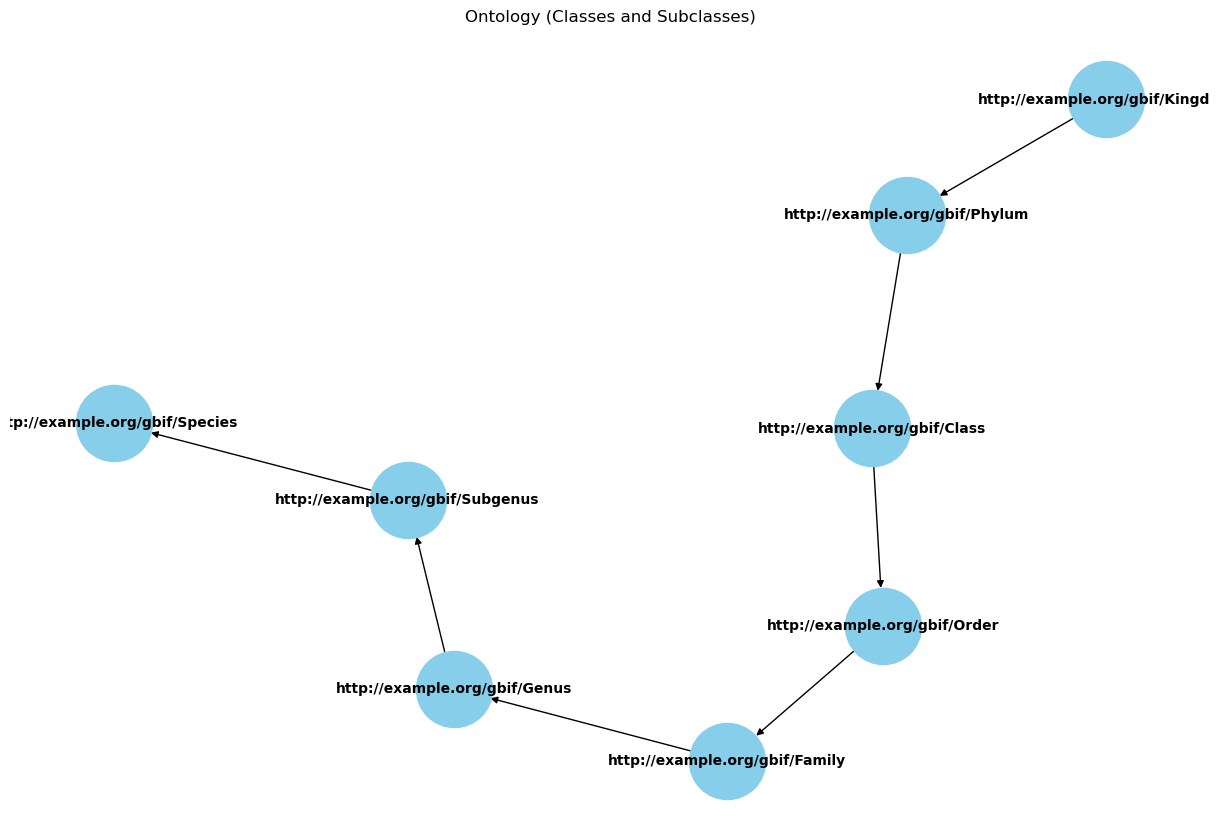

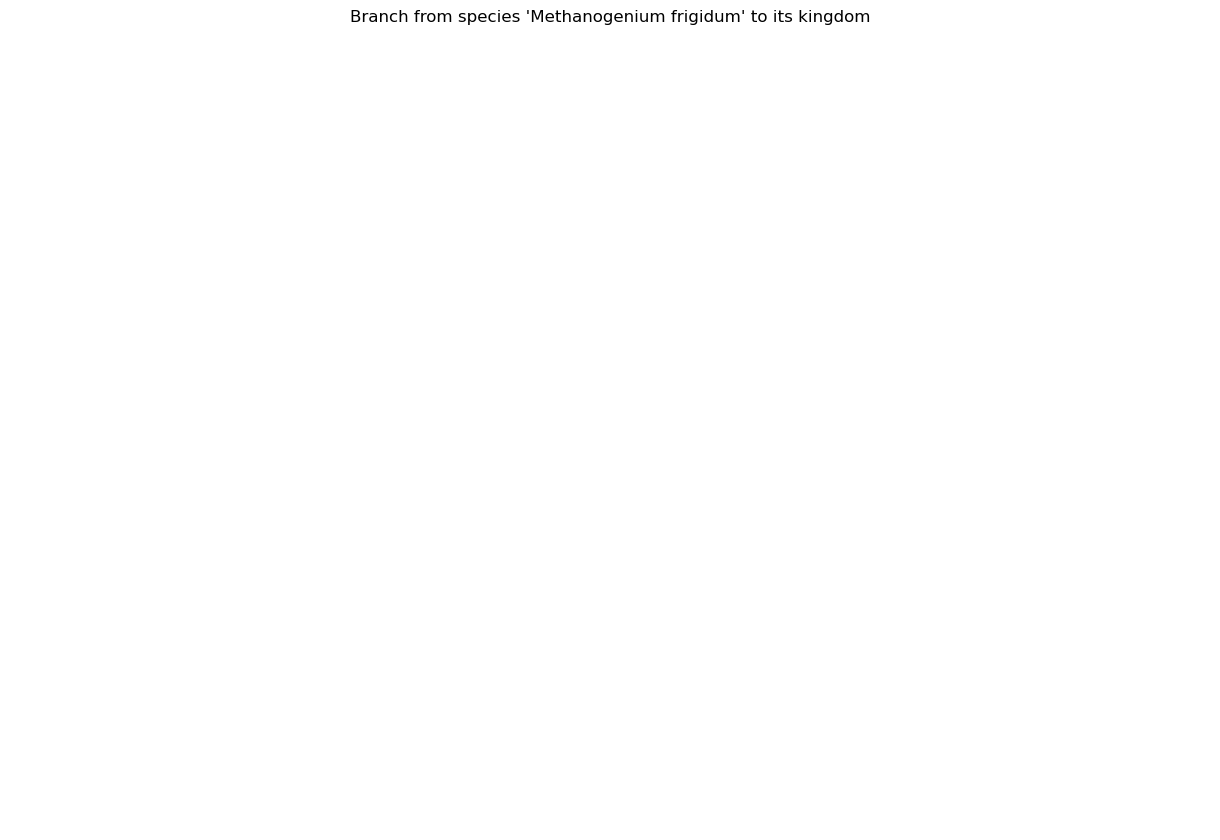

In [32]:
import pandas as pd
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS, OWL
import urllib.parse
import networkx as nx
import matplotlib.pyplot as plt

# Function to create a valid URI from a string
def create_valid_uri(s):
    return URIRef(GBIF + urllib.parse.quote(s.replace(" ", "_")))

# Load the RDF file
rdf_file = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_GBIF.rdf'

# Create RDF graph
g = Graph()
g.parse(rdf_file, format='turtle')

# Define namespaces
GBIF = Namespace("http://example.org/gbif/")
g.bind("gbif", GBIF)

# Function to get the label of a URI
def get_label(uri):
    label = next(g.objects(uri, RDFS.label), None)
    return str(label) if label else str(uri)

# Create a directed graph for the ontology
G_ontology = nx.DiGraph()

# Add classes and their subclass relationships to the graph
for s, p, o in g.triples((None, RDFS.subClassOf, None)):
    G_ontology.add_edge(get_label(o), get_label(s))

# Plot the ontology
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_ontology, k=0.5)
nx.draw(G_ontology, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
plt.title("Ontology (Classes and Subclasses)")
plt.show()

# Function to create a branch graph from species to kingdom
def create_branch_graph(species_name):
    species_uri = create_valid_uri(species_name)
    current_uri = species_uri
    branch_graph = nx.DiGraph()
    previous_label = None
    
    while current_uri:
        label = get_label(current_uri)
        if previous_label:
            branch_graph.add_edge(label, previous_label)
        previous_label = label
        current_uri = next((o for s, p, o in g.triples((current_uri, None, None)) if p in [GBIF.kingdom, GBIF.phylum, GBIF.class_, GBIF.order, GBIF.family, GBIF.genus, GBIF.subgenus]), None)
    
    return branch_graph

# Example species name to create the branch graph
species_name = 'Methanogenium frigidum'
branch_graph = create_branch_graph(species_name)

# Plot the branch graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(branch_graph, k=0.5)
nx.draw(branch_graph, pos, with_labels=True, node_size=3000, node_color="lightgreen", font_size=10, font_weight="bold", arrows=True)
plt.title(f"Branch from species '{species_name}' to its kingdom")
plt.show()


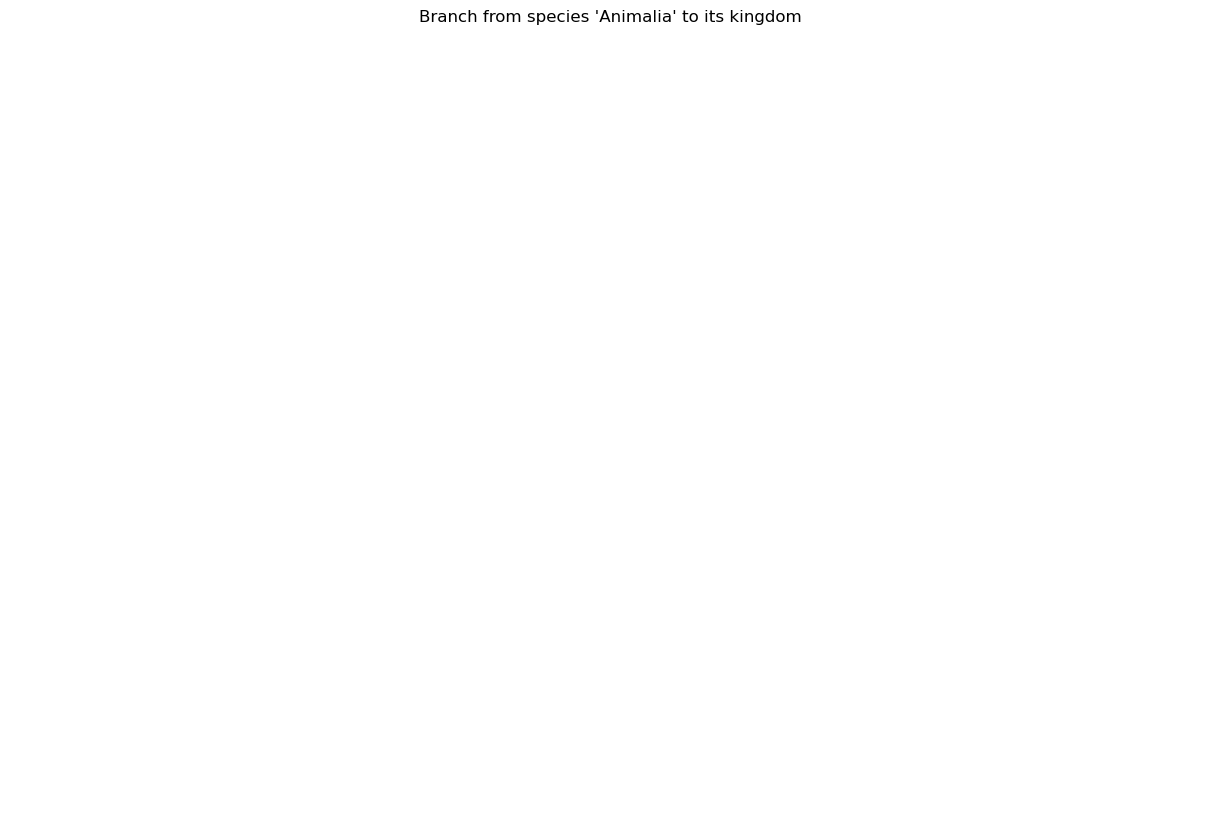

In [35]:
# Example species name to create the branch graph
species_name = 'Animalia'
branch_graph = create_branch_graph(species_name)

# Plot the branch graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(branch_graph, k=0.5)
nx.draw(branch_graph, pos, with_labels=True, node_size=3000, node_color="lightgreen", font_size=10, font_weight="bold", arrows=True)
plt.title(f"Branch from species '{species_name}' to its kingdom")
plt.show()


In [51]:
# Function to create a branch graph from species to kingdom
def create_branch_graph(species_name):
    species_uri = create_valid_uri(species_name)
    current_uri = species_uri
    branch_graph = nx.DiGraph()
    previous_label = None
    hierarchy_predicates = [GBIF.kingdom, GBIF.phylum, GBIF.class_, GBIF.order, GBIF.family, GBIF.genus, GBIF.subgenus]

    while current_uri:
        label = get_label(current_uri)
        print(f"Current URI: {current_uri}, Label: {label}")  # Debug print
        if previous_label:
            branch_graph.add_edge(label, previous_label)
        previous_label = label
        next_uri = None
        for predicate in hierarchy_predicates:
            next_uri = next((o for s, p, o in g.triples((current_uri, predicate, None))), None)
            if next_uri:
                break
        current_uri = next_uri

    return branch_graph

# Example species name to create the branch graph
species_name = 'Stenusconvergens'
branch_graph = create_branch_graph(species_name)

# Check if the branch graph is empty
if branch_graph.number_of_nodes() == 0:
    print(f"No hierarchy found for species '{species_name}'")
else:
    # Plot the branch graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(branch_graph, k=0.5)
    nx.draw(branch_graph, pos, with_labels=True, node_size=3000, node_color="lightgreen", font_size=10, font_weight="bold", arrows=True)
    plt.title(f"Branch from species '{species_name}' to its kingdom")
    plt.show()

Current URI: http://example.org/gbif/Stenusconvergens, Label: http://example.org/gbif/Stenusconvergens
No hierarchy found for species 'Stenusconvergens'


In [47]:

# Function to get items in a given hierarchy level
def get_hierarchy_items(level):
    level_uri = GBIF[level.capitalize()]
    items = []
    for s, p, o in g.triples((None, RDF.type, level_uri)):
        item_name = get_label(s)
        if item_name not in items:
            items.append(item_name)
    return items

# Example usage
hierarchy_level = 'species'  # Change this to any hierarchy level you want to get items for
items = get_hierarchy_items(hierarchy_level)
print(f"List of items in the '{hierarchy_level}' hierarchy:")
for item in items:
    print(item)

List of items in the 'species' hierarchy:
Methanogenium frigidum Franzmann et al., 1997
Methanogenium frigidum
Hexarthra mira (Hudson, 1871)
Hexarthra mira
Habrotrocha angusticollis (Murray, 1905)
Habrotrocha angusticollis
Asplanchna girodi de Guerne, 1888
Asplanchna girodi
Stenus convergens
Lecane inermis (Bryce, 1892)
Lecane inermis
Mycobacterium tuberculosis Zopf, 1883
Mycobacterium tuberculosis
Keratella quadrata (Müller, 1786)
Keratella quadrata
Polysiphonia harveyi J.W.Bailey
Neosiphonia harveyi
Fredericella sultana Blumenbach, 1779
Fredericella sultana
Plumatella emarginata Allmann, 1844
Plumatella emarginata
Lophopus crystallinus (Pallas, 1768)
Lophopus crystallinus
Cristatella mucedo Cuvier, 1798
Cristatella mucedo
Pteridium aquilinum Linnaeus, 1753
Pteridium aquilinum
Eimeria tumlisoni McAllister & Seville, 2012
Eimeria tumlisoni
Megoleria orestilla
Klebsiella pneumoniae Friedländer, 1883
Klebsiella pneumoniae
Oxytenis modoccidentalis
Thalassia testudinum Banks & Sol. ex J.Ko

Wuchereria bancrofti
Pinctada margaritifera (Linnaeus, 1758)
Pinctada margaritifera
Pinctada imbricata Röding, 1798
Pinctada imbricata
Atrina fragilis (Pennant, 1777)
Atrina fragilis
Pinna bicolor Gmelin, 1791
Pinna bicolor
Pinna rudis Linnaeus, 1758
Pinna rudis
Mytilus trossulus A.Gould, 1850
Mytilus trossulus
Mytilus galloprovincialis Lamarck, 1819
Mytilus galloprovincialis
Benthomodiolus lignocola Dell, 1987
Benthomodiolus lignocola
Musculista senhousia (W.H.Benson, 1842)
Arcuatula senhousia
Nodipecten subnodosus (G.B.Sowerby I, 1835)
Nodipecten subnodosus
Aequipecten opercularis (Linnaeus, 1758)
Aequipecten opercularis
Placopecten magellanicus (Gmelin, 1791)
Placopecten magellanicus
Pecten maximus (Linnaeus, 1758)
Pecten maximus
Ostrea edulis Linnaeus, 1758
Ostrea edulis
Crassostrea gigas (Thunberg, 1793)
Magallana gigas
Crassostrea virginica (Gmelin, 1791)
Crassostrea virginica
Bathyarca glacialis (Gray, 1824)
Bathyarca glacialis
Mactromeris polynyma (W.Stimpson, 1860)
Mactromeris

Bos javanicus d'Alton, 1823
Bos javanicus
Hippotragus equinus (É.Geoffroy Saint-Hilaire, 1803)
Hippotragus equinus
Hippotragus niger (Harris, 1838)
Hippotragus niger
Syncerus caffer (Sparrman, 1779)
Syncerus caffer
Redunca fulvorufula (Afzelius, 1815)
Redunca fulvorufula
Damaliscus lunatus (Burchell, 1823)
Damaliscus lunatus
Capra caucasica Güldenstaedt & Pallas, 1783
Capra caucasica
Capra sibirica (Pallas, 1776)
Capra sibirica
Capra pyrenaica Schinz, 1838
Capra pyrenaica
Capra ibex Linnaeus, 1758
Capra ibex
Capra hircus Linnaeus, 1758
Capra hircus
Antidorcas marsupialis (Zimmermann, 1780)
Antidorcas marsupialis
Antilope cervicapra (Linnaeus, 1758)
Antilope cervicapra
Saiga tatarica (Linnaeus, 1766)
Saiga tatarica
Addax nasomaculatus (Blainville, 1816)
Addax nasomaculatus
Connochaetes taurinus (Burchell, 1823)
Connochaetes taurinus
Ovibos moschatus (Zimmermann, 1780)
Ovibos moschatus
Ovis aries Linnaeus, 1758
Ovis aries
Ovis dalli Nelson, 1884
Ovis dalli
Ovis canadensis Shaw, 1804
Ovis

Dactylorhiza majalis (Rchb.) P.F.Hunt & Summerh.
Orchis ×influenza Sennholz
Dactylorhiza influenza
Gastrodia elata Blume
Gastrodia elata
Neottia ovata (L.) Bluff & Fingerh.
Neottia ovata
Cypripedium calceolus L.
Cypripedium calceolus
Habenaria alinae Szlach.
Habenaria alinae
Habenaria monorrhiza (Sw.) Rchb.f.
Habenaria monorrhiza
Angraecum mauritianum (Poir.) Frapp.
Angraecum mauritianum
Angraecum cucullatum Thouars
Angraecum cucullatum
Angraecum bracteosum Balf.f. & S.Moore
Angraecum bracteosum
Angraecum pectinatum Thouars
Angraecum pectinatum
Angraecum ramosum Thouars
Angraecum ramosum
Gymnadenia nigra (L.) Rchb.f.
Gymnadenia nigra
Caladenia huegelii Rchb.f.
Caladenia huegelii
Bulbophyllum prismaticum Thouars
Bulbophyllum prismaticum
Bulbophyllum occultum Thouars
Bulbophyllum occultum
Beclardia macrostachya (Thouars) A.Rich.
Beclardia macrostachya
Orchis ×bergonii Nanteuil
Orchis bergonii
Orchis patens Desf.
Orchis patens
Orchis mascula (L.) L.
Orchis mascula
Orchis spitzelii Saut. e

Physarum polycephalum
Planktothrix rubescens (DC. ex Gomont) Anagn. & Komárek
Planktothrix rubescens
Cylindrospermopsis raciborskii (Wołosz.) Seenayya & Subbaraju
Cylindrospermopsis raciborskii
Bordetella pertussis (Bergey et al., 1923) Moreno-Lopez, 1952
Bordetella pertussis
Cupriavidus necator_C
Cupriavidus necator
Sinorhizobium meliloti_A
Sinorhizobium meliloti
Agrobacterium tumefaciens_C
Agrobacterium tumefaciens
Bartonella elizabethae (Daly et al., 1993) Brenner et al., 1993
Bartonella elizabethae
Bartonella tribocorum_A
Bartonella tribocorum
Roseovarius crassostreae Boettcher et al., 2005
Aliiroseovarius crassostreae
Erythromicrobium ramosum Yurkov et al., 1994
Erythromicrobium ramosum
Wolbachia pipientis Hertig, 1936
Wolbachia pipientis
Roseococcus thiosulfatophilus Yurkov et al., 1994
Roseococcus thiosulfatophilus
Acetobacter pomorum Sokollek et al., 1998
Acetobacter pomorum
Arsenophonus nasoniae Gherna et al., 1991
Arsenophonus nasoniae
Serratia fonticola Gavini et al., 1979
S

Fundulus grandis Baird & Girard, 1853
Fundulus grandis
Poecilia mexicana De Filippi, 1940
Poecilia mexicana
Poecilia sphenops Valenciennes, 1846
Poecilia sphenops
Poecilia latipinna (Lesueur, 1821)
Poecilia latipinna
Lebistes reticulatus (Peters, 1859)
Poecilia formosa (Girard, 1859)
Poecilia formosa
Batrachoides liberiensis (Steindachner, 1867)
Batrachoides liberiensis
Oncorhynchus keta (Walbaum, 1792)
Oncorhynchus keta
Oncorhynchus mykiss (Walbaum, 1792)
Oncorhynchus mykiss
Oncorhynchus tshawytscha (Walbaum, 1792)
Oncorhynchus tshawytscha
Oncorhynchus kisutch (Walbaum, 1792)
Oncorhynchus kisutch
Oncorhynchus gorbuscha (Walbaum, 1792)
Oncorhynchus gorbuscha
Oncorhynchus nerka (Walbaum, 1792)
Oncorhynchus nerka
Albula argentea (Forster, 1801)
Albula argentea
Albula vulpes (Linnaeus, 1758)
Albula vulpes
Albula glossodonta (Forsskål, 1775)
Albula glossodonta
Albula goreensis Valenciennes, 1847
Albula goreensis
Thayeria boehlkei Weitzman, 1957
Thayeria boehlkei
Astyanax mexicanus (De Fili

Cercospora gomphrenae
Pleospora feltgenii
Phoma tremulae Sacc.
Phoma tremulae
Phoma omnivora McAlpine
Phoma omnivora
Barteria fistulosa Mast.
Barteria fistulosa
Cylindropsis parvifolia Pierre
Cylindropsis parvifolia
Alstonia congensis Engl.
Alstonia congensis
Alstonia boonei De Wild.
Alstonia boonei
Anthriscus anthriscus (L.) H.Karst.
Odina antiscorbutica (Hiern) K.Schum.
Lannea antiscorbutica
Anacardium excelsum (Bertero & Balb.) Skeels
Anacardium excelsum
Sterculia rhinopetala K.Schum.
Sterculia rhinopetala
Sterculia oblonga Mast.
Sterculia oblonga
Olea hochstetteri Baker
Olea capensis
Schrebera arborea A.Chev.
Schrebera arborea
Jaundea zenkeri Gilg
Capsella bursa Raf.
Alliaria alliaria (L.) Britton
Mostacillastrum subauriculatum
Stackhousia tryonii F.M.Bailey
Stackhousia monogyna
Aizoon hispanicum L.
Aizoanthemopsis hispanica
Pierreodendron kerstingii (Engl.) Little
Pierreodendron kerstingii
Clusia cuneata Benth.
Clusia cuneata
Clusia grandiflora Splitg.
Clusia grandiflora
Myristica

Arabis alpina Krock. ex Steud.
Arabis sagittata
Picea abies Degen
Carex acuta All., 1785
Eperua falcata Blanco
Afzelia rhomboidea
Ficus natalensis Krauss ex Engl., 1888
Mimusops elengi Bojer
Manilkara kauki
Vanilla planifolia Jacks., 1808
Pteropus rufus E.Geoffroy, 1803
Pteropus rufus
Sambucus nigra Thunb.
Stauroneis phoenicenteron (Nitzsch) Ehrenberg, 1843
Stauroneis phoenicenteron
Pinus strobus Thunb.
Hymenoscyphus pseudoalbidus V.Queloz, C.R.Grünig, R.Berndt, T.Kowalski, T.N.Sieber & O.Holdenrieder
Hymenoscyphus pseudoalbidus
Alchemilla glabra Suffrian
Rosa canina Sm.
Pleuronectes platessa Linnaeus, 1758
Pleuronectes platessa
Dryas octopetala J.G.Gmel.
Armeria maritima Mill.
Armeria maritima
Powelliphanta patrickensis (Powell, 1949)
Powelliphanta patrickensis
Nasturtium officinale R.Br.
Alopecurus bulbosus Poir., 1789
Stipa tenacissima Ucria
Stipellula capensis
Sorbus aucuparia Michx.
Sorbus americana
Bryonia dioica Sessé & Moc.
Reseda phyteuma Kralik ex Müll.Arg.
Reseda arabica
Gop

Silene latifolia (Miller) Britton & Rendle
Malus malus (L.) Britton
Scabiosa stellata Bieb.
Lomelosia micrantha
Cucurbita pepo Lour., 1790
Solidago virgaurea Kit. ex Hornem.
Dipteryx oleifera (Benth.) Ducke
Vanilla bosseri L.Allorge
Vanilla bosseri
Mimegralla contingens
Sedum album Hartm.
Carex pseudocyperus Boeck.
Amaranthus hybridus Hornem.
Acacia tortilis Forssk.
Acacia tortilis
Vitis mesoamericana D.J.Rogers
Vitis mesoamericana
Bactris gasipaes Oerst.
Potamogeton lucens Nolte ex Koch
Geckobia hemidactyli
Trachypithecus mauritius
Macrosaccus robiniella (Clemens, 1859)
Macrosaccus robiniella
Acacia nilotica Schumach. & Thonn.
Acacia nilotica
Allium oleraceum Batt.
Daucus carota Desf.
Arum maculatum Gueldenst. ex Ledeb., 1852
Deroceras invadens Reise, Hutchinson, Schunack & Schlitt, 2011
Deroceras invadens
Cirsium vulgare Lange
Mus domesticus Schwartz & Schwartz, 1943
Potentilla reptans Willd. ex Ledeb.
Alopecurus pratensis Bourg.
Alopecurus arundinaceus
Didelphis peregrinus Boddaert,

In [46]:
len(items)

12126

In [43]:
import pandas as pd
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS, OWL
import urllib.parse

# Load the CSV file
csv_file = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_GBIF.csv'  # Replace with the actual path to the CSV file
df = pd.read_csv(csv_file)

# Create RDF graph
g = Graph()

# Define namespaces
GBIF = Namespace("http://example.org/gbif/")
g.bind("gbif", GBIF)

# Define the hierarchy as per the given structure
hierarchy = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'subgenus', 'species']

# Create ontology classes
for h in hierarchy:
    class_uri = GBIF[h.capitalize()]
    g.add((class_uri, RDF.type, OWL.Class))
    if h != 'kingdom':
        parent_class_uri = GBIF[hierarchy[hierarchy.index(h) - 1].capitalize()]
        g.add((class_uri, RDFS.subClassOf, parent_class_uri))

# Function to create a valid URI from a string
def create_valid_uri(s):
    return URIRef(GBIF + urllib.parse.quote(s.replace(" ", "_")))

# Set to keep track of created entities
created_entities = set()

# Populate the graph with data from CSV
for _, row in df.iterrows():
    entity_uri = create_valid_uri(row['gbif_id'])
    if entity_uri not in created_entities:
        created_entities.add(entity_uri)
        g.add((entity_uri, RDF.type, GBIF[row['rank'].capitalize()]))
        g.add((entity_uri, RDFS.label, Literal(row['scientificName'])))
        
        for h in hierarchy:
            if pd.notna(row[h]):
                parent_uri = create_valid_uri(row[h])
                if parent_uri not in created_entities:
                    created_entities.add(parent_uri)
                    g.add((parent_uri, RDF.type, GBIF[h.capitalize()]))
                    g.add((parent_uri, RDFS.label, Literal(row[h])))
                g.add((entity_uri, GBIF[h], parent_uri))

        g.add((entity_uri, GBIF['name'], Literal(row['name'])))
        g.add((entity_uri, GBIF['scientificName'], Literal(row['scientificName'])))
        g.add((entity_uri, GBIF['canonicalName'], Literal(row['canonicalName'])))
        g.add((entity_uri, GBIF['rank'], Literal(row['rank'])))

# Serialize the graph to an RDF file
output_file = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_GBIF.rdf'
g.serialize(destination=output_file, format='turtle')

print(f'RDF file has been created: {output_file}')


RDF file has been created: C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_GBIF.rdf


## To JSON

In [5]:
import json
df = pd.read_csv('C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_GBIF.csv')

# Save the JSON data to a file
output_file = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_GBIF.json'


In [6]:
# Define the hierarchy as per the given structure
hierarchy = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'subgenus', 'species']

# Create a dictionary to hold the JSON structure
data = {}

# Populate the dictionary with data from CSV
for _, row in df.iterrows():
    entity = {
        'gbif_id': row['gbif_id'],
        'name': row['name'],
        'scientificName': row['scientificName'],
        'canonicalName': row['canonicalName'],
        'rank': row['rank'],
        'hierarchy': {}
    }
    for h in hierarchy:
        if pd.notna(row[h]):
            entity['hierarchy'][h] = row[h]

    if row['rank'].lower() not in data:
        data[row['rank'].lower()] = []
    data[row['rank'].lower()].append(entity)

# Serialize the dictionary to a JSON file
with open(output_file, 'w') as f:
    json.dump(data, f, indent=4)

print(f'JSON file has been created: {output_file}')

JSON file has been created: C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_GBIF.json
